[<font color='steelblue'>1. - __EDA__</font>](#one-bullet) <br>
    [<font color='steelblue'>1.1. - Imports</font>](#two-bullet) <br>
    [<font color='steelblue'>1.2. - Data Exploration</font>](#three-bullet) <br>
    [<font color='steelblue'>1.3. - Data Preprocessing</font>](#four-bullet) <br>
    [<font color='steelblue'>1.4. - Corpus Splitting</font>](#five-bullet) <br>
    [<font color='steelblue'>1.5. - Feature Engineering</font>](#six-bullet) <br>
    [<font color='steelblue'>1.6. - SMOTE</font>](#seven-bullet) <br>

[<font color='steelblue'>2. - __Models__</font>](#eight-bullet) <br>
    [<font color='steelblue'>2.1. - Functions</font>](#nine-bullet) <br>
    [<font color='steelblue'>2.2. - Models</font>](#ten-bullet) <br>
    [<font color='steelblue'>2.3. - PreTrained Models</font>](#eleven-bullet) <br> 
    [<font color='steelblue'>2.4. - Hyperparameter tuning</font>](#twelve-bullet) <br>
    [<font color='steelblue'>2.5. - Evaluation</font>](#thirteen-bullet) <br>

Group 7
|Name | Student ID |
|----|----|
|Joana Rodrigues| 20240603|
|Mara Simões| 20240326|
|Matilde Street| 20240523|
|Rafael Silva| 20240511|

<hr>
<a class="anchor" id="one-bullet"> 
<d style="color:white;">

# 1. EDA
</a> 
</d>   

<a class="anchor" id="two-bullet"> 
<d style="color:white;">

## 1.1. Imports
</a> 
</d>   

In [ ]:
# Basic utilities for data handling, analysis, and visualization
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Progress bar for loops and long-running processes
from tqdm import tqdm

# Tools for creating visual representations of text
from wordcloud import WordCloud

# Core NLP tools for text cleaning, tokenization, and linguistic processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from textblob import TextBlob

# Machine learning tools for model training, evaluation, and vectorization
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, precision_score, recall_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier

# Word embedding and vectorization using Gensim
from gensim.models import Word2Vec
import gensim.downloader

# Neural networks and deep learning using Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Masking
from tensorflow.keras.utils import to_categorical

# Transformers and pre-trained models from Hugging Face
import torch
from transformers import (
    BertTokenizer, BertModel, RobertaTokenizer, RobertaModel,
    MarianMTModel, MarianTokenizer, AutoTokenizer, AutoModel, pipeline
)
import tensorflow_hub as hub

# Additional libraries for advanced modeling and preprocessing
import xgboost as xgb
import fasttext
from imblearn.over_sampling import SMOTE

# Hyperparameter tuning 
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# to read our data

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train = pd.DataFrame(data=df_train, columns=['text', 'label']).reset_index(drop=True)
df_test = pd.DataFrame(data=df_test, columns=['text', 'label']).reset_index(drop=True)

print(df_train.head())

                                                text  label
0  $BYND - JPMorgan reels in expectations on Beyo...      0
1  $CCL $RCL - Nomura points to bookings weakness...      0
2  $CX - Cemex cut at Credit Suisse, J.P. Morgan ...      0
3  $ESS: BTIG Research cuts to Neutral https://t....      0
4  $FNKO - Funko slides after Piper Jaffray PT cu...      0


In [4]:
# copy of the df to apply in pre-trained models without data cleaning
df_train_raw = df_train.copy()

<a class="anchor" id="three-bullet"> 
<d style="color:white;">

## 1.2. Data Exploration
</a> 
</d>   

In [5]:
print('Initial dataset contains ', df_train.shape[0], 'rows and ', df_train.shape[1], 'columns')

Initial dataset contains  9543 rows and  2 columns


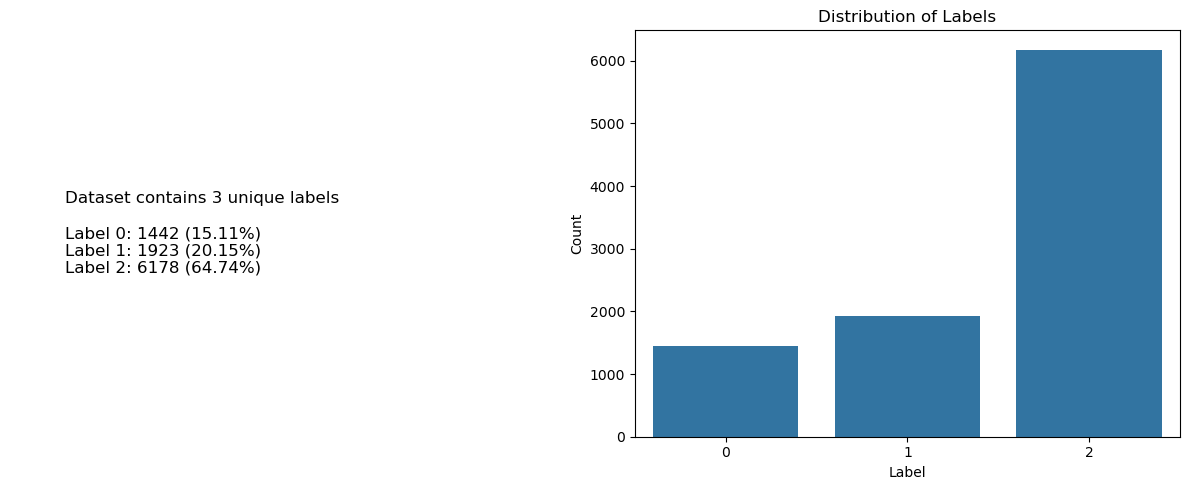

In [6]:
label_counts = df_train['label'].value_counts()
total = label_counts.sum()
label_percent = (label_counts / total * 100).round(2)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

textstr = '\n'.join([f'Label {label}: {count} ({percent}%)' 
                     for label, count, percent in zip(label_counts.sort_index().index, 
                                                      label_counts.sort_index().values, 
                                                      label_percent.sort_index().values)])

axs[0].text(0.1, 0.5, f'Dataset contains {df_train["label"].nunique()} unique labels\n\n{textstr}', 
            fontsize=12, verticalalignment='center')
axs[0].axis('off')

sns.countplot(data=df_train, x='label', order=[0, 1, 2], ax=axs[1])
axs[1].set_title("Distribution of Labels")
axs[1].set_xlabel("Label")
axs[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

To see the words that appear the most in our dataset

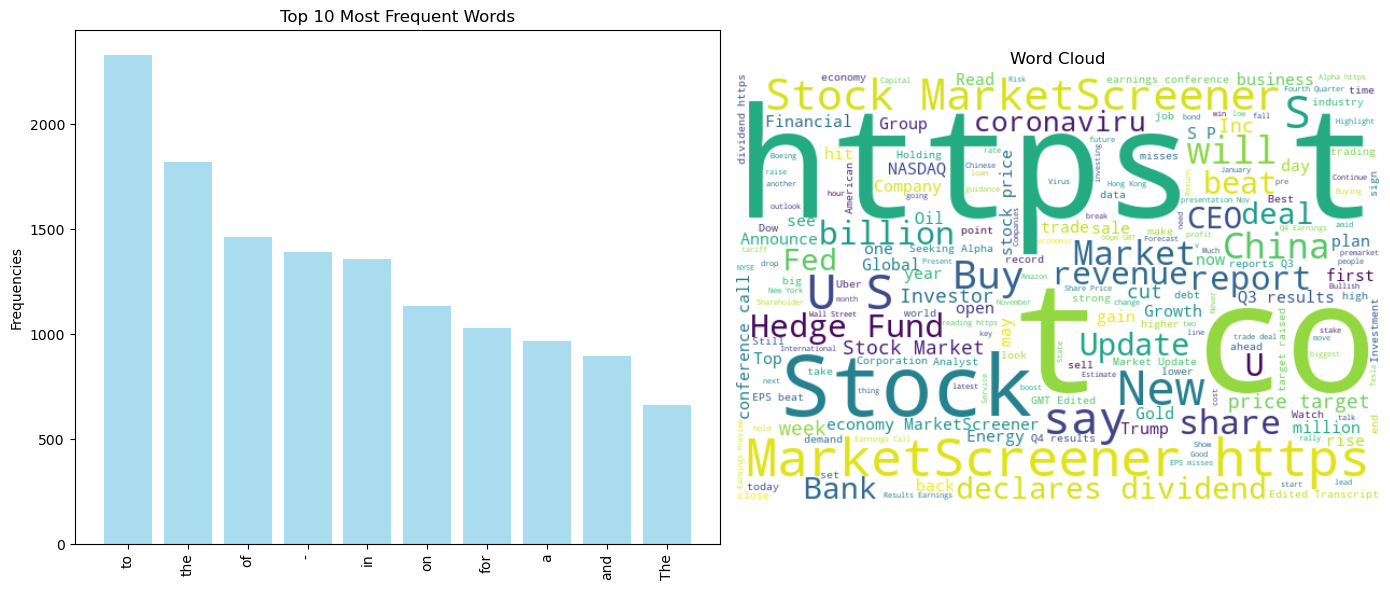

In [7]:
all_words = ' '.join(df_train['text']).split()
freq = pd.Series(all_words).value_counts()

x_labels = freq.index[0:10]
values = freq[:10]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].bar(x_labels, values, align='center', alpha=0.7, color='skyblue')
axes[0].set_xticks(range(len(x_labels)))
axes[0].set_xticklabels(x_labels, rotation=90)
axes[0].set_ylabel('Frequencies')
axes[0].set_title('Top 10 Most Frequent Words')

wordcloud = WordCloud(width=600, height=400, background_color='white').generate(' '.join(all_words))
axes[1].imshow(wordcloud, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Word Cloud')

plt.tight_layout()
plt.show()

There appears the same word 'the' for example twice because it is in lower and upper case. Therefore we will have to deal with that in the preprocessing steps.

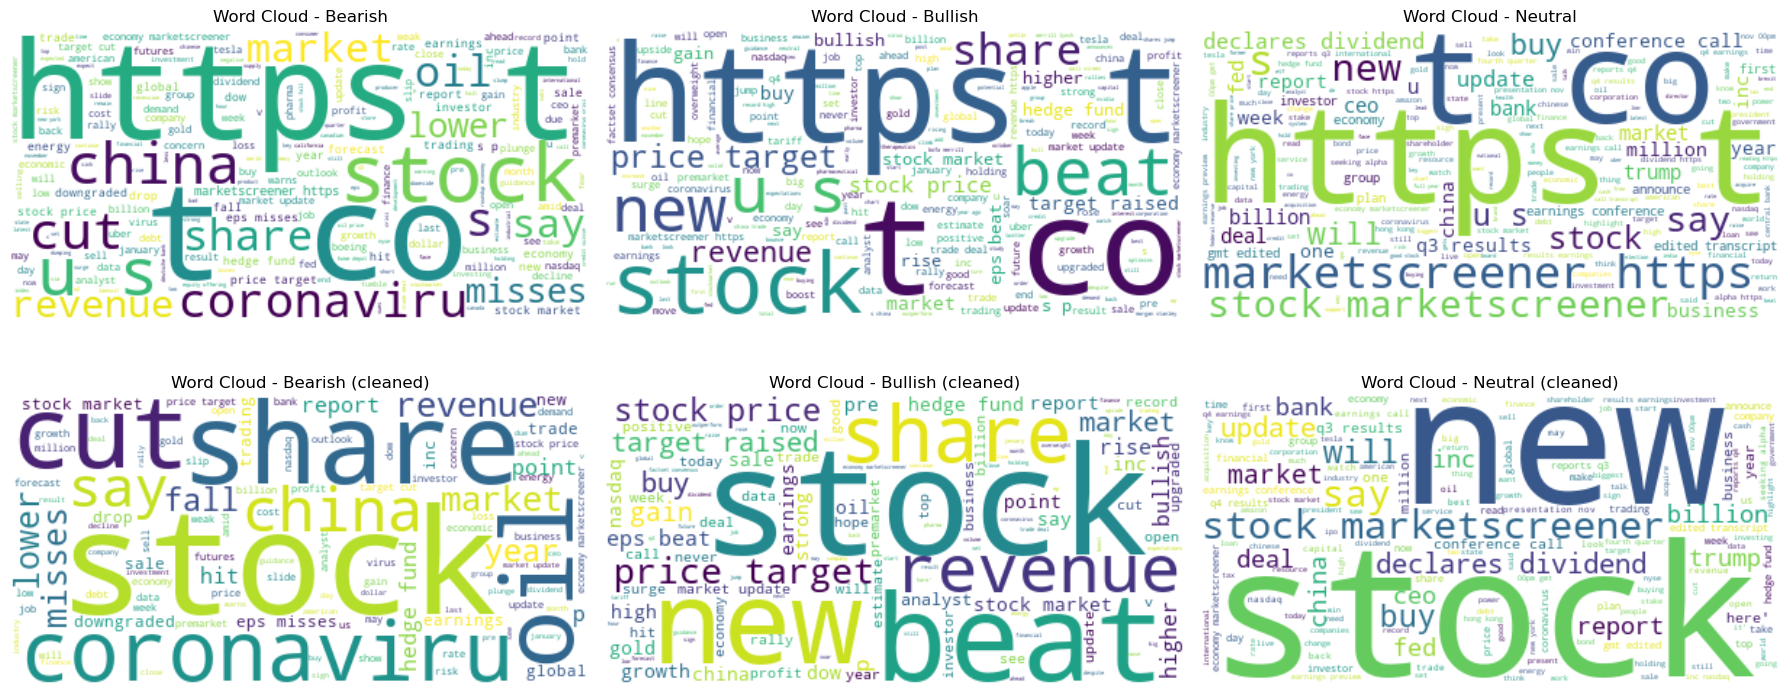

In [8]:
def generate_wordcloud(text):
    return WordCloud(width=400, height=200, background_color='white').generate(text)

def remove_words(text, words_to_remove):
    pattern = r'\b(' + '|'.join(words_to_remove) + r')\b'
    return re.sub(pattern, '', text)

texts = {
    'Bearish': ' '.join(df_train[df_train['label'] == 0]['text'].fillna('').str.lower()),
    'Bullish': ' '.join(df_train[df_train['label'] == 1]['text'].fillna('').str.lower()),
    'Neutral': ' '.join(df_train[df_train['label'] == 2]['text'].fillna('').str.lower()),
}

words_to_remove = ['https', 't', 'co', 'u', 's']

fig, axs = plt.subplots(2, 3, figsize=(18, 8))

for i, (label, text) in enumerate(texts.items()):
    wc = generate_wordcloud(text)
    axs[0, i].imshow(wc, interpolation='bilinear')
    axs[0, i].axis('off')
    axs[0, i].set_title(f'Word Cloud - {label}')

for i, (label, text) in enumerate(texts.items()):
    cleaned_text = remove_words(text, words_to_remove)
    wc = generate_wordcloud(cleaned_text)
    axs[1, i].imshow(wc, interpolation='bilinear')
    axs[1, i].axis('off')
    axs[1, i].set_title(f'Word Cloud - {label} (cleaned)')

plt.tight_layout()
plt.show()

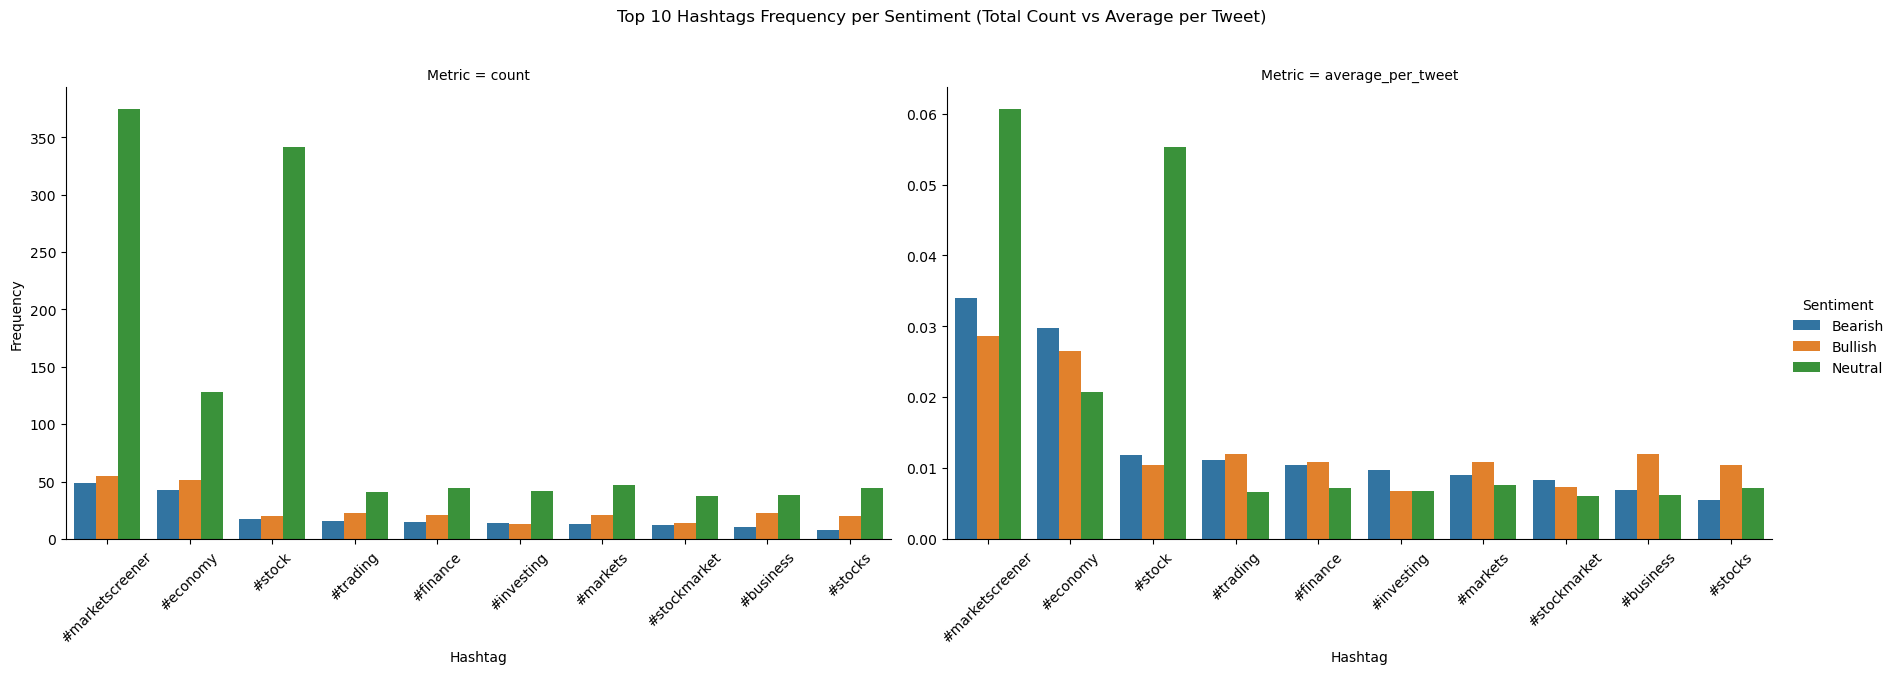

In [ ]:
# Function to extract hashtags from a text string
def extract_hashtags(text):
    return re.findall(r'#\w+', text.lower())

# Add a new column with the list of hashtags per tweet
df_train['hashtags'] = df_train['text'].apply(extract_hashtags)

# Explode so each row corresponds to one hashtag
df_hashtags = df_train.explode('hashtags')

# Count total occurrences of each hashtag within each label
top_hashtags = df_hashtags.groupby(['label', 'hashtags']).size().reset_index(name='count')

# Count number of tweets per label (for averaging)
tweets_per_label = df_train.groupby('label').size().reset_index(name='tweet_count')

# Merge counts with tweet totals to compute average occurrences per tweet
top_hashtags = top_hashtags.merge(tweets_per_label, on='label')
top_hashtags['average_per_tweet'] = top_hashtags['count'] / top_hashtags['tweet_count']

# Select top 10 hashtags per label by total count
top10_hashtags = top_hashtags.groupby('label').apply(lambda x: x.nlargest(10, 'count')).reset_index(drop=True)

# Map numeric labels to names
label_map = {0: 'Bearish', 1: 'Bullish', 2: 'Neutral'}
top10_hashtags['label_name'] = top10_hashtags['label'].map(label_map)

# Melt into long form for side-by-side plotting (total vs. average)
df_melted = top10_hashtags.melt(
    id_vars=['label_name', 'hashtags'],
    value_vars=['count', 'average_per_tweet'],
    var_name='Metric',
    value_name='Value'
)

g = sns.catplot(
    data=df_melted,
    x='hashtags',
    y='Value',
    hue='label_name',
    col='Metric',
    kind='bar',
    height=6,
    aspect=1.5,
    sharey=False
)

g.set_xticklabels(rotation=45)
g.set_axis_labels("Hashtag", "Frequency")
g._legend.set_title('Sentiment')
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Top 10 Hashtags Frequency per Sentiment (Total Count vs Average per Tweet)')
plt.show()

<a class="anchor" id="four-bullet"> 
<d style="color:white;">

## 1.3. Data Preprocessing
</a> 
</d>   

### 1.3.1. Missing values and duplicated rows

In [10]:
if df_train.isnull().sum().sum() > 0:
    print('There are missing values in the dataset')
else: 
    print('There are no missing values in the dataset')  

There are no missing values in the dataset


In [11]:
dups = df_train[df_train.duplicated(subset=['text', 'label'], keep=False)]
print(f"Duplicated: {dups.shape[0]} rows")

Duplicated: 0 rows


### 1.3.2. New Features  

To help us visualize the content of our dataset, we will create two new columns: one that counts the total number of characters in each tweet, and another that counts the total number of words.

In [12]:
df_train['text_length'] = df_train['text'].apply(len)
df_train['word_count']  = df_train['text'].apply(lambda x: len(str(x).split(" ")))

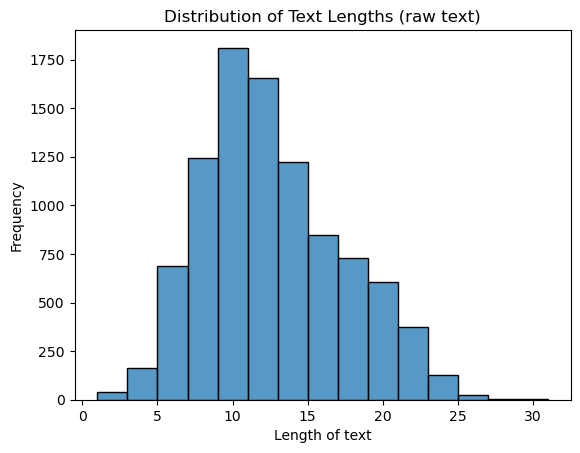

In [13]:
#Plot distribution of text length
sns.histplot(df_train['word_count'], bins=15)
plt.title("Distribution of Text Lengths (raw text)")
plt.xlabel("Length of text")
plt.ylabel("Frequency")
plt.show()

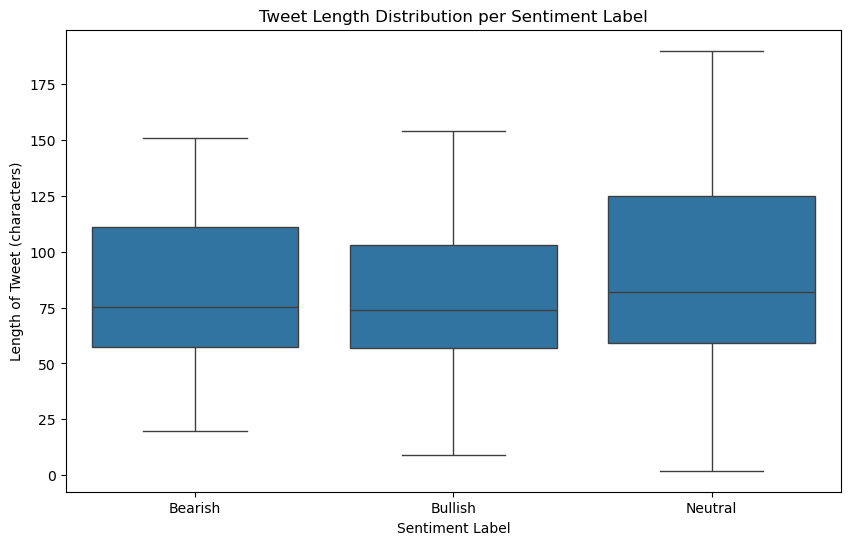

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_train, x='label', y='text_length')
plt.title('Tweet Length Distribution per Sentiment Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Length of Tweet (characters)')
plt.xticks([0, 1, 2], ['Bearish', 'Bullish', 'Neutral'])
plt.show()

In [15]:
df_train.word_count.describe()

count    9543.000000
mean       12.168081
std         4.651245
min         1.000000
25%         9.000000
50%        11.000000
75%        15.000000
max        31.000000
Name: word_count, dtype: float64

### 1.3.3. Outliers   

In [ ]:
to_remove = df_train['text_length'].quantile(0.005)

print('We will eliminate the texts with less than', to_remove, 'length')  #0.5 percentile

# to see where the labels of the errors
removed_labels = df_train[df_train['text_length'] < to_remove]['label'].value_counts()
print(removed_labels)

# to see what is being eliminated:
removed = df_train.loc[df_train['text_length'] < to_remove, ['text', 'label', 'text_length']]
print(removed)

df_train = df_train[df_train['text_length'] >= to_remove]
df_train = df_train[df_train['text_length'] >= to_remove].reset_index(drop=True)

We will eliminate the texts with less than 18.0 length
label
2    42
1     5
Name: count, dtype: int64
                   text  label  text_length
1858   SASA聚酯选用英威达PTA技术      2           16
3090          Brent +4%      1            9
3943                 :)      2            2
3948            @TicToc      2            7
3980      100% Correct!      2           13
4358  Cya Jason Garrett      2           17
4360               Damn      2            4
4440                 F5      2            2
4914         Next week.      2           10
5006      Racing on Ice      2           13
5484    Wholesale Trade      2           15
5512         Woke Sachs      2           10
5654         $penn coin      2           10
6511     Housing Starts      2           14
6849     Nasdaq up 0.2%      1           14
6990  Averages end flat      2           17
7935      $WW heavy....      1           13
8055          Long $WMT      1            9
8153    $APOP on scans.      2           15
8167       $CEI W

### 1.3.4. All text in english   

In [17]:
model = fasttext.load_model("lid.176.bin")

def detect_language_fasttext(text):
    try:
        text_cleaned = text.replace('\n', ' ').strip()
        prediction = model.predict(text_cleaned)[0][0]
        return prediction.replace("__label__", "")
    except:
        return "unknown"

df_train['language'] = df_train['text'].apply(detect_language_fasttext)
print(df_train['language'].value_counts())

language
en    9420
de      21
es      14
it      10
fr       8
nl       6
ja       5
pt       3
fi       2
hu       1
vi       1
sv       1
cs       1
zh       1
da       1
is       1
Name: count, dtype: int64


In [18]:
SUPPORTED_LANGS = ['en', 'fr', 'es', 'de', 'it', 'nl', 'ru', 'zh', 'ja', 'ar', 'fi', 'hu', 'vi', 'sv', 'cs', 'da', 'is']
loaded_models = {}

def load_translation_model(src_lang):
    model_name = f'Helsinki-NLP/opus-mt-{src_lang}-en'
    if model_name not in loaded_models:
        tokenizer = MarianTokenizer.from_pretrained(model_name)
        model = MarianMTModel.from_pretrained(model_name)
        loaded_models[model_name] = (tokenizer, model)
    return loaded_models[model_name]

def translate_text(text, src_lang):
    if src_lang == 'en' or src_lang not in SUPPORTED_LANGS:
        return text  
    try:
        tokenizer, model = load_translation_model(src_lang)
        batch = tokenizer([text], return_tensors="pt", padding=True, truncation=True)
        generated = model.generate(**batch)
        translated = tokenizer.decode(generated[0], skip_special_tokens=True)
        return translated
    except Exception as e:
        print(f"Error translating ({src_lang}): {e}")
        return text

df_train['translated_text'] = [
    translate_text(text, lang)
    for text, lang in tqdm(zip(df_train['text'], df_train['language']), total=len(df_train))]


# to see it its translating well:
df_train[df_train['language'] == 'fr']

100%|██████████| 9496/9496 [06:22<00:00, 24.83it/s] 


,text,label,hashtags,text_length,word_count,language,translated_text
1449,Eudonet annonce un chiffre d’affaires récurren...,2,[],82,13,fr,Eudonet announces a 32% increase in recurring ...
1837,Rio Tinto’s Giant Mongolia Project Dealt Anoth...,2,[],53,6,fr,Rio Tinto的s Giant Mongolia Project Dealt Anoth...
1961,Tinyclues accélère sa croissance en 2019,2,[],40,6,fr,Tinyclues accelerates its growth in 2019
4313,Cloudia lance la dernière génération de soluti...,2,[],93,13,fr,Cloudia launches the latest generation of Proc...
4777,Korian s’associe à Omedys pour développer le p...,2,[],114,16,fr,Korian is partnering with Omedys to develop th...
5342,Total : Résultats du quatrième trimestre et de...,2,[],59,10,fr,Total: Results for the fourth quarter and the ...
5488,Will China Declare Force Majeure If Virus Situ...,2,[],60,9,fr,Will China Declare Force Major If Virus Situat...
8672,Is Les Hôtels de Paris (EPA:HDP) Using Too Muc...,2,[],53,10,fr,Is Hotels in Paris (EPA:HDP) Using Too Much Debt?


### 1.3.5. Text cleaning  

Application of a formula that will:
1. Remove the stopwords
2. Stemeatize & Lematize
3. Put everything in lowercase
3. Remove weird characters

In [19]:
# Set of English stopwords to filter out common, uninformative words
stop = set(stopwords.words('english'))
print(stop)

# Snowball stemmer to reduce words to their root form
stemmer = SnowballStemmer('english')

# WordNet lemmatizer to convert words to their base or dictionary form
lemma = WordNetLemmatizer()


# Cleaning Function
def clean(text_list, stopwords=True, lemmatize=True, stem=False, correct_spelling=False):
    """
    Clean a list of text strings by applying lowercasing, regex filters, and optional NLP steps.

    Parameters:
    text_list (list): List of text entries (strings) to clean.
    stopwords (bool): If True, removes English stopwords.
    lemmatize (bool): If True, applies lemmatization to each word.
    stem (bool): If True, applies stemming to each word (not recommended with lemmatization).
    correct_spelling (bool): If True, applies spelling correction (slow process).

    Returns:
    list: List of cleaned text strings.
    """

    cleaned = []
    for text in tqdm(text_list):
        text = text.lower()                                            # convert text to lowercase
        text = re.sub(r"http\S+", "", text)                            # remove links
        text = re.sub("[^a-zA-Z]", " ", text)                          # remove numbers and non-alphabetic characters
        text = re.sub("br", "", text)                                  # remove occurrences of "br" (often from HTML tags)
        text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)  # remove extra punctuation
        

        if stopwords:
            text = " ".join([word for word in text.split() if word not in stop])

        if correct_spelling:
            text = str(TextBlob(text).correct())

        if lemmatize:
            text = " ".join(lemma.lemmatize(word) for word in text.split())

        if stem:
            text = " ".join(stemmer.stem(word) for word in text.split())

        cleaned.append(text)

    return cleaned

# Initial cleaning: remove empty or None entries
df_train = df_train[df_train['translated_text'].notnull()]
df_train = df_train[df_train['translated_text'].str.strip() != ""]

# Apply cleaning function
df_train['clean_text'] = clean(df_train['translated_text'], stopwords=True, lemmatize=True, stem=False, correct_spelling=False)

# View original and cleaned texts
df_train[['text', 'clean_text']].head()

{'be', 'again', 'other', 'as', "don't", "hadn't", 'are', "mightn't", 'needn', 'those', 'too', 'above', 'here', 'some', 'where', 'd', 'on', 'there', "haven't", 'very', 'below', 'now', "he'd", "she'll", 'after', 'can', 'against', 'wasn', 'before', 'into', 'any', 'been', 'hers', "you'll", "he's", 'in', 'weren', "it'd", 'ma', 'with', 'how', 'or', 'until', 're', "you'd", 'than', 'should', 'am', 'me', 'll', 'my', 'from', 'our', 'if', "they've", "we'll", 'have', "needn't", 'between', "wouldn't", 'who', 'during', "you've", "doesn't", 'because', "we're", "weren't", "i've", 'her', 'them', 'were', 'is', 'they', "couldn't", 'same', "we've", 'yours', 'most', 'theirs', 'of', 'each', 'no', 'that', 've', 'do', "i'll", 'won', 'only', 'ain', "they'd", 'his', 'the', 'himself', 'myself', 'does', 'it', 't', 'up', 'themselves', 'you', 'had', 'itself', 'did', 'further', 'all', 'hadn', 'yourselves', "hasn't", 'over', 'yourself', 'to', 'i', 'few', 'more', 'own', "she'd", 'mightn', 's', 'their', "didn't", 'your

100%|██████████| 9496/9496 [00:02<00:00, 3944.24it/s]


,text,clean_text
0,$BYND - JPMorgan reels in expectations on Beyo...,bynd jpmorgan reel expectation beyond meat
1,$CCL $RCL - Nomura points to bookings weakness...,ccl rcl nomura point booking weakness carnival...
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",cx cemex cut credit suisse j p morgan weak bui...
3,$ESS: BTIG Research cuts to Neutral https://t....,es btig research cut neutral
4,$FNKO - Funko slides after Piper Jaffray PT cu...,fnko funko slide piper jaffray pt cut


### 1.3.6. Removing unsual words  

To further reduce noise in our dataset and improve the potential performance of our models, we will remove all words that appear only once in the dataset, as these are extremely rare and likely insignificant for our problem.

In [20]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_train['clean_text'])
words = vectorizer.get_feature_names_out()
word_counts = X.toarray().sum(axis=0)
words_once = [word for word, count in zip(words, word_counts) if count == 1]

print("Words that appear only once:", words_once)

Words that appear only once: ['aaa', 'aaham', 'aams', 'aaon', 'aav', 'aaww', 'abalone', 'abandoned', 'abandoning', 'abbott', 'abe', 'abebe', 'aben', 'abeo', 'aberdeen', 'abeviated', 'abiy', 'abn', 'abo', 'abolish', 'aborted', 'absol', 'absorb', 'absurdity', 'abu', 'abukarsh', 'abusing', 'abv', 'academic', 'acc', 'acceleron', 'acceleronpharma', 'accendowave', 'acceptance', 'accessing', 'accesswi', 'accommodate', 'accomplish', 'accomplished', 'accor', 'accordingly', 'accretive', 'accumulated', 'accumulating', 'accuracy', 'accurately', 'accusation', 'accuses', 'acea', 'acelerada', 'acelrx', 'ach', 'achieved', 'achieving', 'acknowledged', 'acknowledging', 'acme', 'acmr', 'acorncapitalinvestmentfund', 'acqu', 'acquittal', 'acrx', 'actinogen', 'actinogenmedical', 'activated', 'activates', 'activism', 'actuall', 'actuarial', 'acu', 'acui', 'acw', 'adam', 'adani', 'adapt', 'addict', 'addicted', 'adecco', 'adenatfriedman', 'adesco', 'adesto', 'adia', 'adidas', 'adjusting', 'adjustment', 'adjuva

In [21]:
words_once_set = set(words_once)

def remove_rare_words(text):
    """
    Remove words from a text string that appear only once in the training corpus.

    Parameters:
    text (str): The input text to clean.

    Returns:
    str: The text with rare words removed (i.e., words that appear only once in the corpus).
    """
    
    return ' '.join([word for word in text.split() if word not in words_once_set])

df_train['clean_text'] = df_train['clean_text'].apply(remove_rare_words)

<a class="anchor" id="five-bullet"> 
<d style="color:white;">

## 1.4. Corpus Splitting
</a> 
</d>   

Since we initially preserved the original content of our dataset, we will use it to test two different modeling approaches. The first uses the cleaned version of our dataset, with all the preprocessing steps applied throughout this notebook, which will be used for more traditional models (e.g. Logistic Regression and KNN). The second approach uses the untouched, original version of the dataset, which will be used with pre-trained models such as BERT and RoBERTa. To proceed, we begin by splitting each version of the dataset into training and validation sets.

In [22]:
# SPLIT FOR MODELS WITH CLEANED TEXT
X_train = df_train['clean_text']
y_train = df_train['label'] 

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=df_train['label'], random_state=42)

In [ ]:
# SPLIT FOR MODELS WITH RAW TEXT (FOR PRE-TRAINED MODELS)
X_raw = df_train_raw['text']
y_raw = df_train_raw['label']

X_train_raw, X_val_raw, y_train_raw, y_val_raw = train_test_split(X_raw, y_raw, test_size=0.2, stratify=y_raw, random_state=42)

<a class="anchor" id="six-bullet"> 
<d style="color:white;">

## 1.5. Feature Engineering
</a> 
</d>   

In [24]:
def bow_or_tfidf(texts = df_train['clean_text'], method='bow'):
    """
    Convert a list of text documents into a numerical feature matrix using either
    Bag of Words (BoW) or TF-IDF vectorization.

    Parameters:
    texts (list or pandas Series): Collection of text documents to vectorize.
    method (str): Vectorization method to use. Must be either 'bow' or 'tfidf'.

    Returns:
    tuple: A tuple containing:
        - X (scipy sparse matrix): The document-term matrix.
        - vectorizer (CountVectorizer or TfidfVectorizer): The fitted vectorizer instance.

    Raises:
    ValueError: If the provided method is not 'bow' or 'tfidf'.
    """
    
    if method == 'bow':
        vectorizer = CountVectorizer()
        X = vectorizer.fit_transform(texts)
        return X, vectorizer

    elif method == 'tfidf':
        vectorizer = TfidfVectorizer()
        X = vectorizer.fit_transform(texts)
        return X, vectorizer

    else:
        raise ValueError("Choose a valid method: 'bow', 'tfidf'.")

### 1.5.1. Bag of Words (BoW) 

In [25]:
X_train_bow, vectorizer = bow_or_tfidf(X_train, method='bow')
X_val_bow = vectorizer.transform(X_val)

### 1.5.2. TF-IDF  

In [26]:
X_train_tfidf, vectorizer = bow_or_tfidf(X_train, method='tfidf')
X_val_tfidf = vectorizer.transform(X_val)

### 1.5.3 Word2Vec

In [27]:
# Train the model only once using the training data
tokenized_train = [text.split() for text in X_train]
model = Word2Vec(
    sentences=tokenized_train,
    vector_size=100,   
    window=2,          
    min_count=1,       # Minimum word frequency to be included
    sg=1               # Skip-gram model (if 0, uses CBOW)
)
word_vectors = model.wv  # Extract trained word vectors

def get_doc_embedding(doc, word_vectors, dim=100):
    """
    Convert a text document into a single vector by averaging its word embeddings.

    Parameters:
    doc (str): The document (string of text) to embed.
    word_vectors (gensim KeyedVectors): Trained word embeddings.
    dim (int): The dimensionality of the embeddings (default is 100).

    Returns:
    numpy.ndarray: The averaged vector representing the document.
                   If no known words are found, returns a zero vector.
    """
    tokens = doc.split()
    vectors = [word_vectors[word] for word in tokens if word in word_vectors.index_to_key]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(dim)

# Generate document-level embeddings by averaging the vectors of each word
X_train_w2v = np.vstack([get_doc_embedding(doc, word_vectors) for doc in X_train])
X_val_w2v = np.vstack([get_doc_embedding(doc, word_vectors) for doc in X_val])


### 1.5.4 GloVe  

In [ ]:
model_name = 'glove-twitter'
emb_size = 100

w2v = gensim.downloader.load(f'{model_name}-{emb_size}')

def corpus2vec(corpus, w2v):
    """
    Convert a list of text documents into lists of word vectors using a pre-trained GloVe model.

    Parameters:
    corpus (list): List of strings, each representing a document (e.g., tweet).
    w2v (gensim KeyedVectors): Pre-trained word vectors loaded via gensim.

    Returns:
    list: A list where each element is a list of word vectors corresponding to the words in a document.
    """
    index_set = set(w2v.index_to_key)  # For fast lookup
    word_vec = w2v.get_vector          # Shortcut for faster access
    return [
        [word_vec(word) for word in doc.split() if word in index_set]
        for doc in tqdm(corpus)
    ]

# Apply to training and validation data
x_train_vec = corpus2vec(X_train, w2v)
x_val_vec = corpus2vec(X_val, w2v)

# Function to convert each tweet into a single vector (average of its word vectors)
def average_vectors(vector_list, dim):
    """
    Compute the average vector for a list of word vectors.
    If the list is empty, return a zero vector.

    Parameters:
    vector_list (list): List of word vectors (e.g., from a tweet).
    dim (int): Dimensionality of the embeddings.

    Returns:
    numpy.ndarray: Averaged vector representation of the input list.
    """
    return np.mean(vector_list, axis=0) if vector_list else np.zeros(dim)

# Generate averaged document embeddings for training and validation sets
X_train_glove_avg = np.vstack([average_vectors(vecs, emb_size) for vecs in x_train_vec])
X_val_glove_avg = np.vstack([average_vectors(vecs, emb_size) for vecs in x_val_vec])

100%|██████████| 1900/1900 [00:00<00:00, 33512.81it/s]


In [29]:
# Just a simple test to understand the results and performance of the model
w2v.most_similar('happy', topn=10)

[('birthday', 0.9259342551231384),
 ('day', 0.8549738526344299),
 ('bday', 0.814542829990387),
 ('merry', 0.7886533141136169),
 ('love', 0.7855905890464783),
 ('wish', 0.7771798372268677),
 ('hope', 0.7660956978797913),
 ('thank', 0.7639737725257874),
 ('year', 0.7505833506584167),
 ('thanks', 0.7475084066390991)]

### 1.5.5 RoBERTa  

In [ ]:
# Load pretrained RoBERTa model and tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')
model.eval()  # Set to eval mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Function to convert corpus to embeddings (Corpus2Vec using [CLS] token)
def roberta_corpus2vec(corpus, tokenizer, model, max_length=128):
    """
    Generate sentence embeddings for a list of documents using the [CLS] token from RoBERTa.

    Parameters:
    corpus (list): List of raw text documents (e.g., tweets).
    tokenizer (transformers.PreTrainedTokenizer): Tokenizer corresponding to the RoBERTa model.
    model (transformers.PreTrainedModel): Pretrained RoBERTa model.
    max_length (int): Maximum sequence length to tokenize each document.

    Returns:
    np.ndarray: Matrix of embeddings, one per document (shape: num_docs × hidden_size).
    """
    
    embeddings = []
    with torch.no_grad():
        for doc in tqdm(corpus):
            inputs = tokenizer(doc, return_tensors='pt', padding='max_length',
                               truncation=True, max_length=max_length)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze(0)  # CLS token
            embeddings.append(cls_embedding.cpu().numpy())
    return np.vstack(embeddings)

# Encode train, validation and test sets with original (raw) text
# This is the best embedding that's why we do it for the test set as well
X_train_roberta = roberta_corpus2vec(X_train_raw, tokenizer, model)
X_val_roberta = roberta_corpus2vec(X_val_raw, tokenizer, model)
df_test_roberta = roberta_corpus2vec(df_test['text'], tokenizer, model)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 2388/2388 [04:07<00:00,  9.64it/s]


### 1.5.6. BERTweet

In [31]:
# Load pretrained BERTweet model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=True)
model = AutoModel.from_pretrained("vinai/bertweet-base")
model.eval()  # Set to evaluation mode

def bertweet_corpus2vec(corpus, tokenizer, model, max_length=128):
    """
    Generate sentence embeddings for a list of documents using the [CLS] token from BERTweet.

    Parameters:
    corpus (list): List of raw text documents (e.g., tweets).
    tokenizer (transformers.PreTrainedTokenizer): Tokenizer for BERTweet.
    model (transformers.PreTrainedModel): Pretrained BERTweet model.
    max_length (int): Maximum token length to truncate/pad each document.

    Returns:
    np.ndarray: Matrix of embeddings, one per document (shape: num_docs × hidden_size).
    """
    embeddings = []
    with torch.no_grad():
        for doc in tqdm(corpus, desc="BERTweet Encoding"):
            inputs = tokenizer(
                doc,
                return_tensors="pt",
                padding="max_length",
                truncation=True,
                max_length=max_length
            )
            outputs = model(**inputs)
            cls_emb = outputs.last_hidden_state[:, 0, :].squeeze(0) 
            embeddings.append(cls_emb.cpu().numpy())
    return np.vstack(embeddings)

# Encode train and validation sets with original (raw) text
X_train_bertweet = bertweet_corpus2vec(X_train_raw.tolist(), tokenizer, model)
X_val_bertweet   = bertweet_corpus2vec(X_val_raw.tolist(), tokenizer, model)

BERTweet Encoding: 100%|██████████| 1909/1909 [03:11<00:00,  9.96it/s]


### 1.5.7. Universal Sentence Encoder (USE)

In [32]:
# Load pretrained Universal Sentence Encoder model
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def use_corpus2vec(corpus):
    """
    Generate sentence embeddings for a list of documents using the Universal Sentence Encoder.

    Parameters:
    corpus (list): List of raw text documents (e.g., tweets).

    Returns:
    np.ndarray: Matrix of embeddings, one per document (shape: num_docs × 512).
    """
    embeddings = []
    for doc in tqdm(corpus, desc="USE Encoding"):
        emb = use_model([doc])
        embeddings.append(emb.numpy()[0])
    return np.vstack(embeddings)

# Encode train and validation sets with original (raw) text
X_train_use = use_corpus2vec(X_train_raw.tolist())
X_val_use = use_corpus2vec(X_val_raw.tolist())


USE Encoding: 100%|██████████| 1909/1909 [00:01<00:00, 1042.66it/s]


<a class="anchor" id="seven-bullet"> 
<d style="color:white;">

## 1.6. SMOTE
</a> 
</d>   

We are going to use SMOTE to handle data imbalance in some models where is not possible to apply class weights.

In [33]:
# Juste to check if the trains have the same size and the smote will work
print(X_train_raw.shape)
print(y_train_raw.shape)

(7634,)
(7634,)


In [34]:
smote = SMOTE(random_state=13)

X_train_roberta_resampled, y_train_resampled = smote.fit_resample(X_train_roberta, y_train_raw)

# X_train_glove_avg_resampled, y_train_resampled = smote.fit_resample(X_train_glove_avg, y_train)
# X_train_emb_resampled, y_train_resampled = smote.fit_resample(X_train_emb, y_train)
# X_train_bow_resampled, y_train_resampled = smote.fit_resample(X_train_bow, y_train)
# X_train_tfidf_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

<hr>
<a class="anchor" id="eight-bullet"> 
<d style="color:white;">

# 2. Models
</a> 
</d>   

<a class="anchor" id="nine-bullet"> 
<d style="color:white;">

## 2.1. Functions
</a> 
</d>   

Function for evaluation of all models

In [35]:
def evaluate_model_predictions(y_pred_train, y_pred_val, y_train = y_train, y_val = y_val, show_confusion_matrix = True, show_classification_report = True):
    """
    Evaluate the performance of a classification model on training and validation sets.

    Computes and prints accuracy, F1-score (macro), precision, and recall for both sets.
    Optionally displays the confusion matrix and detailed classification report for the validation set.

    Parameters:
    y_pred_train (array-like): Predicted labels for the training set.
    y_pred_val (array-like): Predicted labels for the validation set.
    y_train (array-like, optional): True labels for the training set.
    y_val (array-like, optional): True labels for the validation set.
    show_confusion_matrix (bool): If True, prints the confusion matrix for the validation set.
    show_classification_report (bool): If True, prints the classification report for the validation set.

    Returns:
    tuple: A tuple containing:
        - train_accuracy (float)
        - train_f1 (float)
        - val_accuracy (float)
        - val_f1 (float)
    """
    
    # to get the accurancy and the macro f1 score of the model on the training set
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train, average='macro')
    
    # to get the accurancy and the macro f1 score of the model on the validation set
    val_accuracy = accuracy_score(y_val, y_pred_val)
    val_f1 = f1_score(y_val, y_pred_val, average='macro')

    # to get the precision and the recall of the model on the validation set
    val_precision = precision_score(y_val, y_pred_val, average='macro')
    val_recall = recall_score(y_val, y_pred_val, average='macro')

    print(f"Accuracy of train: {train_accuracy:.4f}")
    print(f"F1 Macro (Train): {train_f1:.4f}")
    print(f"Accuracy of val: {val_accuracy:.4f}")
    print(f"\033[1mF1 Macro (Val)\033[0m: {val_f1:.4f}")
    print(f"Precision (Val): {val_precision:.4f}")
    print(f"Recall (Val): {val_recall:.4f}")
    
    # to get the confusion matrix and the classification report of the model on the validation set
    if show_confusion_matrix==True:
        print('\nConfusion Matrix for Validation Data:')    
        print(confusion_matrix(y_val, y_pred_val))

    if show_classification_report==True:
        print('\nClassification Report for Validation Data:')
        print(classification_report(y_val, y_pred_val))

    return val_accuracy, val_f1, val_precision, val_recall

<a class="anchor" id="ten-bullet"> 
<d style="color:white;">

## 2.2. Models
</a> 
</d> 

In this section all different combinations of embeddings and well-known models will be tested.

### 2.2.1. Naive Bayes

#### With BOW

In [36]:
nb = MultinomialNB()
nb.fit(X_train_bow, y_train)
y_pred_train = nb.predict(X_train_bow)
y_pred_val = nb.predict(X_val_bow)

nb_bow_accuracy, nb_bow_f1_macro, nb_bow_precision, nb_bow_recall = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val=y_pred_val)

Accuracy of train: 0.8838
F1 Macro (Train): 0.8475
Accuracy of val: 0.7716
F1 Macro (Val): 0.6794
Precision (Val): 0.6991
Recall (Val): 0.6651

Confusion Matrix for Validation Data:
[[ 142   52   94]
 [  26  237  121]
 [  61   80 1087]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.62      0.49      0.55       288
           1       0.64      0.62      0.63       384
           2       0.83      0.89      0.86      1228

    accuracy                           0.77      1900
   macro avg       0.70      0.67      0.68      1900
weighted avg       0.76      0.77      0.77      1900



#### With TF-IDF

In [37]:
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred_train = nb.predict(X_train_tfidf)
y_pred_val = nb.predict(X_val_tfidf)

# Results
nb_idf_accuracy, nb_idf_f1_macro, nb_idf_precision, nb_idf_recall = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val=y_pred_val)

Accuracy of train: 0.7838
F1 Macro (Train): 0.6419
Accuracy of val: 0.7353
F1 Macro (Val): 0.5351
Precision (Val): 0.8240
Recall (Val): 0.5023

Confusion Matrix for Validation Data:
[[  46   17  225]
 [   3  138  243]
 [   0   15 1213]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.94      0.16      0.27       288
           1       0.81      0.36      0.50       384
           2       0.72      0.99      0.83      1228

    accuracy                           0.74      1900
   macro avg       0.82      0.50      0.54      1900
weighted avg       0.77      0.74      0.68      1900



#### With Word2Vec

In [38]:
gnb = GaussianNB()
gnb.fit(X_train_w2v, y_train)
y_pred_train = gnb.predict(X_train_w2v)
y_pred_val = gnb.predict(X_val_w2v)

# Results
nb_w2v_accuracy, nb_w2v_f1_macro, nb_w2v_precision, nb_w2v_recall = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val=y_pred_val)

Accuracy of train: 0.3737
F1 Macro (Train): 0.3522
Accuracy of val: 0.3842
F1 Macro (Val): 0.3497
Precision (Val): 0.4391
Recall (Val): 0.4042

Confusion Matrix for Validation Data:
[[176  44  68]
 [227  84  73]
 [667  91 470]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.16      0.61      0.26       288
           1       0.38      0.22      0.28       384
           2       0.77      0.38      0.51      1228

    accuracy                           0.38      1900
   macro avg       0.44      0.40      0.35      1900
weighted avg       0.60      0.38      0.43      1900



#### With GloVe

In [39]:
gnb = GaussianNB()
gnb.fit(X_train_glove_avg, y_train)
y_pred_train = gnb.predict(X_train_glove_avg)
y_pred_val = gnb.predict(X_val_glove_avg)

# Results
nb_glove_accuracy, nb_glove_f1_macro, nb_glove_precision, nb_glove_recall = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val=y_pred_val)

Accuracy of train: 0.6356
F1 Macro (Train): 0.5462
Accuracy of val: 0.6389
F1 Macro (Val): 0.5456
Precision (Val): 0.5374
Recall (Val): 0.5599

Confusion Matrix for Validation Data:
[[122  65 101]
 [ 67 205 112]
 [141 200 887]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.37      0.42      0.39       288
           1       0.44      0.53      0.48       384
           2       0.81      0.72      0.76      1228

    accuracy                           0.64      1900
   macro avg       0.54      0.56      0.55      1900
weighted avg       0.67      0.64      0.65      1900



#### With RoBERTa

In [40]:
gnb = GaussianNB()
gnb.fit(X_train_roberta, y_train_raw)
y_pred_train = gnb.predict(X_train_roberta)
y_pred_val = gnb.predict(X_val_roberta)

# Results
nb_roberta_accuracy, nb_roberta_f1_macro, nb_roberta_precision, nb_roberta_recall = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val=y_pred_val, y_train = y_train_raw, y_val = y_val_raw)

Accuracy of train: 0.6504
F1 Macro (Train): 0.5639
Accuracy of val: 0.6590
F1 Macro (Val): 0.5653
Precision (Val): 0.5558
Recall (Val): 0.5853

Confusion Matrix for Validation Data:
[[122  79  87]
 [ 80 231  74]
 [171 160 905]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.33      0.42      0.37       288
           1       0.49      0.60      0.54       385
           2       0.85      0.73      0.79      1236

    accuracy                           0.66      1909
   macro avg       0.56      0.59      0.57      1909
weighted avg       0.70      0.66      0.67      1909



#### With BERTweet

In [41]:
gnb = GaussianNB()
gnb.fit(X_train_bertweet, y_train_raw)
y_pred_train = gnb.predict(X_train_bertweet)
y_pred_val = gnb.predict(X_val_bertweet)

# Results
nb_bertweet_accuracy, nb_bertweet_f1_macro, nb_bertweet_precision, nb_bertweet_recall = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val=y_pred_val, y_train = y_train_raw, y_val = y_val_raw)

Accuracy of train: 0.6912
F1 Macro (Train): 0.5965
Accuracy of val: 0.7103
F1 Macro (Val): 0.6115
Precision (Val): 0.6068
Recall (Val): 0.6191

Confusion Matrix for Validation Data:
[[133  59  96]
 [ 72 227  86]
 [143  97 996]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.38      0.46      0.42       288
           1       0.59      0.59      0.59       385
           2       0.85      0.81      0.83      1236

    accuracy                           0.71      1909
   macro avg       0.61      0.62      0.61      1909
weighted avg       0.72      0.71      0.72      1909



#### With USE

In [42]:
gnb = GaussianNB()
gnb.fit(X_train_use, y_train_raw)
y_pred_train = gnb.predict(X_train_use)
y_pred_val = gnb.predict(X_val_use)

# Results
nb_use_accuracy, nb_use_f1_macro, nb_use_precision, nb_use_recall = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val=y_pred_val, y_train = y_train_raw, y_val = y_val_raw)

Accuracy of train: 0.6635
F1 Macro (Train): 0.5916
Accuracy of val: 0.6737
F1 Macro (Val): 0.5945
Precision (Val): 0.5838
Recall (Val): 0.6144

Confusion Matrix for Validation Data:
[[151  62  75]
 [ 63 224  98]
 [114 211 911]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.46      0.52      0.49       288
           1       0.45      0.58      0.51       385
           2       0.84      0.74      0.79      1236

    accuracy                           0.67      1909
   macro avg       0.58      0.61      0.59      1909
weighted avg       0.70      0.67      0.68      1909



After testing the Naive Bayes model with our embedding techniques, we observed distinct performance patterns across the methods.

Among all tested embeddings, the Bag of Words (BoW) representation yielded the best overall performance in terms of macro F1-score on the validation set, a crucial metric when handling imbalanced classes. It also achieved the highest recall, indicating better class coverage, and demonstrated strong robustness during training, with notably higher accuracy and F1-score than other methods.

While TF-IDF delivered the highest precision, this came with a significant drop in recall and F1-score, suggesting that the model might be focusing too narrowly on distinctive terms, potentially overfitting the data.

Pre-trained embeddings such as GloVe and Word2Vec underperformed when used with Gaussian Naive Bayes, likely due to the loss of contextual nuance when averaging embeddings.

On the other hand, BERTweet and Universal Sentence Encoder (USE) embeddings presented an unusual behavior: they achieved higher accuracy on the validation set than on the training set. This could be due to noise or imbalance in the training data, or better generalization capacity over the validation set, and deserves further exploration.

Overall, BoW is the most reliable and balanced embedding for this model, offering solid performance across all key metrics.

### 2.2.2. Logistic Regression 

#### With BOW

In [43]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train_bow, y_train)
y_pred_train = lr.predict(X_train_bow)
y_pred_val = lr.predict(X_val_bow)

# Results:
lr_bow_accuracy, lr_bow_f1_macro, lr_bow_precision, lr_bow_recall = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val =y_pred_val)

Accuracy of train: 0.9508
F1 Macro (Train): 0.9397
Accuracy of val: 0.7758
F1 Macro (Val): 0.6990
Precision (Val): 0.6962
Recall (Val): 0.7028

Confusion Matrix for Validation Data:
[[ 178   42   68]
 [  47  243   94]
 [  90   85 1053]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.57      0.62      0.59       288
           1       0.66      0.63      0.64       384
           2       0.87      0.86      0.86      1228

    accuracy                           0.78      1900
   macro avg       0.70      0.70      0.70      1900
weighted avg       0.78      0.78      0.78      1900



#### With TF-IDF

In [44]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced') 
lr.fit(X_train_tfidf, y_train)
y_pred_train = lr.predict(X_train_tfidf)
y_pred_val = lr.predict(X_val_tfidf)

# Results:
lr_idf_accuracy, lr_idf_f1_macro, lr_idf_precision, lr_idf_recall = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val =y_pred_val)

Accuracy of train: 0.9057
F1 Macro (Train): 0.8843
Accuracy of val: 0.7784
F1 Macro (Val): 0.7028
Precision (Val): 0.6994
Recall (Val): 0.7074

Confusion Matrix for Validation Data:
[[ 181   41   66]
 [  48  244   92]
 [  89   85 1054]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.57      0.63      0.60       288
           1       0.66      0.64      0.65       384
           2       0.87      0.86      0.86      1228

    accuracy                           0.78      1900
   macro avg       0.70      0.71      0.70      1900
weighted avg       0.78      0.78      0.78      1900



#### With Word2Vec

In [45]:
clf = LogisticRegression(max_iter=1000, class_weight='balanced')
clf.fit(X_train_w2v, y_train)
y_pred_train = clf.predict(X_train_w2v)
y_pred_val = clf.predict(X_val_w2v)

lr_w2v_accuracy, lr_w2v_f1_macro, lr_w2v_precision, lr_w2v_recall = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val =y_pred_val)

Accuracy of train: 0.5446
F1 Macro (Train): 0.4507
Accuracy of val: 0.5432
F1 Macro (Val): 0.4316
Precision (Val): 0.4338
Recall (Val): 0.4380

Confusion Matrix for Validation Data:
[[ 88  72 128]
 [101 134 149]
 [245 173 810]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.20      0.31      0.24       288
           1       0.35      0.35      0.35       384
           2       0.75      0.66      0.70      1228

    accuracy                           0.54      1900
   macro avg       0.43      0.44      0.43      1900
weighted avg       0.58      0.54      0.56      1900



#### With GloVe

In [46]:
clf = LogisticRegression(max_iter=1000, class_weight='balanced')
clf.fit(X_train_glove_avg, y_train)
y_pred_train = clf.predict(X_train_glove_avg)
y_pred_val = clf.predict(X_val_glove_avg)

lr_glove_accuracy, lr_glove_f1_macro, lr_glove_precision, lr_glove_recall = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val =y_pred_val)

Accuracy of train: 0.6331
F1 Macro (Train): 0.5738
Accuracy of val: 0.6284
F1 Macro (Val): 0.5627
Precision (Val): 0.5520
Recall (Val): 0.5998

Confusion Matrix for Validation Data:
[[159  61  68]
 [ 73 226  85]
 [206 213 809]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.36      0.55      0.44       288
           1       0.45      0.59      0.51       384
           2       0.84      0.66      0.74      1228

    accuracy                           0.63      1900
   macro avg       0.55      0.60      0.56      1900
weighted avg       0.69      0.63      0.65      1900



#### With Roberta

In [47]:
# Train classifier with balanced class weights
clf = LogisticRegression(max_iter=1000, class_weight='balanced')
clf.fit(X_train_roberta, y_train_raw)

# Predict and evaluate
y_pred_train = clf.predict(X_train_roberta)
y_pred_val = clf.predict(X_val_roberta)

lr_roberta_accuracy, lr_roberta_f1_macro, lr_roberta_precision, lr_roberta_recall = evaluate_model_predictions(y_pred_train, y_pred_val, y_train=y_train_raw, y_val=y_val_raw)

Accuracy of train: 0.8055
F1 Macro (Train): 0.7636
Accuracy of val: 0.7988
F1 Macro (Val): 0.7446
Precision (Val): 0.7271
Recall (Val): 0.7735

Confusion Matrix for Validation Data:
[[ 218   31   39]
 [  46  283   56]
 [ 125   87 1024]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.56      0.76      0.64       288
           1       0.71      0.74      0.72       385
           2       0.92      0.83      0.87      1236

    accuracy                           0.80      1909
   macro avg       0.73      0.77      0.74      1909
weighted avg       0.82      0.80      0.81      1909



#### With BERTweet

In [48]:
clf = LogisticRegression(max_iter=1000, class_weight='balanced')
clf.fit(X_train_bertweet, y_train_raw)
y_pred_train = clf.predict(X_train_bertweet)
y_pred_val = clf.predict(X_val_bertweet)

lr_bertweet_accuracy, lr_bertweet_f1_macro, lr_bertweet_precision, lr_bertweet_recall = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val =y_pred_val, y_train=y_train_raw, y_val=y_val_raw)

Accuracy of train: 0.8101
F1 Macro (Train): 0.7693
Accuracy of val: 0.7837
F1 Macro (Val): 0.7300
Precision (Val): 0.7096
Recall (Val): 0.7616

Confusion Matrix for Validation Data:
[[210  37  41]
 [ 39 288  58]
 [125 113 998]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.56      0.73      0.63       288
           1       0.66      0.75      0.70       385
           2       0.91      0.81      0.86      1236

    accuracy                           0.78      1909
   macro avg       0.71      0.76      0.73      1909
weighted avg       0.81      0.78      0.79      1909



#### With USE

In [49]:
clf = LogisticRegression(max_iter=1000, class_weight='balanced')
clf.fit(X_train_use, y_train_raw)
y_pred_train = clf.predict(X_train_use)
y_pred_val = clf.predict(X_val_use)

lr_use_accuracy, lr_use_f1_macro, lr_use_precision, lr_use_recall = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val =y_pred_val, y_train=y_train_raw, y_val=y_val_raw)

Accuracy of train: 0.7123
F1 Macro (Train): 0.6591
Accuracy of val: 0.6962
F1 Macro (Val): 0.6330
Precision (Val): 0.6168
Recall (Val): 0.6737

Confusion Matrix for Validation Data:
[[192  48  48]
 [ 75 243  67]
 [172 170 894]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.44      0.67      0.53       288
           1       0.53      0.63      0.57       385
           2       0.89      0.72      0.80      1236

    accuracy                           0.70      1909
   macro avg       0.62      0.67      0.63      1909
weighted avg       0.75      0.70      0.71      1909



After evaluating the Logistic Regression model, among all combinations, RoBERTa showed the best overall performance. It achieved the highest accuracy (0.7988), macro F1-score (0.7446), precision, and recall, indicating not only confident predictions but also a strong ability to capture true positives across all classes.

Close behind was BERTweet, which also delivered robust and balanced results (F1 Macro: 0.7300; Accuracy: 0.7837), showing that transformer-based sentence embeddings are particularly effective for this classification task. These models likely benefit from their pre-training on large and diverse textual data, which helps generalize well even to short texts like tweets.

TF-IDF and BoW also maintained competitive performance, with very similar macro F1-scores (BoW: 0.6990, TF-IDF: 0.7028) and accuracy around 0.775–0.778. These traditional methods proved reliable, especially considering their simplicity and lower computational cost.

On the other hand, Word2Vec and GloVe, when used with Logistic Regression, fell short compared to the other embeddings. GloVe showed moderate results (F1 Macro: 0.5627), while Word2Vec underperformed across all metrics. This suggests that averaging static word embeddings might be too simplistic for capturing the nuances in tweet-level sentiment, especially in short texts with high variability.

Finally, Universal Sentence Encoder (USE) achieved a macro F1-score of 0.6330 and accuracy of 0.6962, placing it in the mid-range among the tested embeddings. While USE generalized reasonably well, it did not match the contextual richness of the transformer-based embeddings.

In summary, RoBERTa combined with Logistic Regression delivered the most consistent and effective results, closely followed by BERTweet.

### 2.2.3. KNN

#### With BOW

In [50]:
knn = KNeighborsClassifier(n_neighbors=5) 
knn.fit(X_train_bow, y_train)
y_pred_train = knn.predict(X_train_bow)
y_pred_val = knn.predict(X_val_bow)

knn_bow_accuracy, knn_bow_f1_macro, knn_bow_precision, knn_bow_recall = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val=y_pred_val)

Accuracy of train: 0.8140
F1 Macro (Train): 0.7225
Accuracy of val: 0.7042
F1 Macro (Val): 0.5258
Precision (Val): 0.6506
Recall (Val): 0.4980

Confusion Matrix for Validation Data:
[[  66   31  191]
 [  14  128  242]
 [  22   62 1144]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.65      0.23      0.34       288
           1       0.58      0.33      0.42       384
           2       0.73      0.93      0.82      1228

    accuracy                           0.70      1900
   macro avg       0.65      0.50      0.53      1900
weighted avg       0.68      0.70      0.66      1900



#### With TF-IDF

In [51]:
knn = KNeighborsClassifier(n_neighbors=5) 
knn.fit(X_train_tfidf, y_train)
y_pred_train = knn.predict(X_train_tfidf)
y_pred_val = knn.predict(X_val_tfidf)

knn_idf_accuracy, knn_idf_f1_macro, knn_idf_precision, knn_idf_recall = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val =y_pred_val)

Accuracy of train: 0.8283
F1 Macro (Train): 0.7424
Accuracy of val: 0.7037
F1 Macro (Val): 0.4740
Precision (Val): 0.7296
Recall (Val): 0.4544

Confusion Matrix for Validation Data:
[[  48    8  232]
 [  14   82  288]
 [   5   16 1207]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.72      0.17      0.27       288
           1       0.77      0.21      0.33       384
           2       0.70      0.98      0.82      1228

    accuracy                           0.70      1900
   macro avg       0.73      0.45      0.47      1900
weighted avg       0.72      0.70      0.64      1900



#### With Word2Vec

In [52]:
knn = KNeighborsClassifier(n_neighbors=5) 
knn.fit(X_train_w2v, y_train)
y_pred_train = knn.predict(X_train_w2v)
y_pred_val = knn.predict(X_val_w2v)

knn_w2v_accuracy, knn_w2v_f1_macro, knn_w2v_precision, knn_w2v_recall = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val =y_pred_val)

Accuracy of train: 0.7449
F1 Macro (Train): 0.6290
Accuracy of val: 0.6089
F1 Macro (Val): 0.4425
Precision (Val): 0.4519
Recall (Val): 0.4379

Confusion Matrix for Validation Data:
[[ 61  57 170]
 [ 69 117 198]
 [115 134 979]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.25      0.21      0.23       288
           1       0.38      0.30      0.34       384
           2       0.73      0.80      0.76      1228

    accuracy                           0.61      1900
   macro avg       0.45      0.44      0.44      1900
weighted avg       0.58      0.61      0.59      1900



#### With GloVe

In [53]:
knn = KNeighborsClassifier(n_neighbors=5) 
knn.fit(X_train_glove_avg, y_train)
y_pred_train = knn.predict(X_train_glove_avg)
y_pred_val = knn.predict(X_val_glove_avg)

knn_glove_accuracy, knn_glove_f1_macro, knn_glove_precision, knn_glove_recall = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val =y_pred_val)

Accuracy of train: 0.8045
F1 Macro (Train): 0.7290
Accuracy of val: 0.7053
F1 Macro (Val): 0.5891
Precision (Val): 0.5954
Recall (Val): 0.5843

Confusion Matrix for Validation Data:
[[ 119   65  104]
 [  63  193  128]
 [  69  131 1028]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.47      0.41      0.44       288
           1       0.50      0.50      0.50       384
           2       0.82      0.84      0.83      1228

    accuracy                           0.71      1900
   macro avg       0.60      0.58      0.59      1900
weighted avg       0.70      0.71      0.70      1900



#### With Roberta

In [54]:
clf_knn = KNeighborsClassifier(n_neighbors=5)
clf_knn.fit(X_train_roberta, y_train_raw)
y_pred_train = clf_knn.predict(X_train_roberta)
y_pred_val = clf_knn.predict(X_val_roberta)

knn_roberta_accuracy, knn_roberta_f1_macro, knn_roberta_precision, knn_roberta_recall = evaluate_model_predictions(y_pred_train, y_pred_val, y_train=y_train_raw, y_val=y_val_raw)

Accuracy of train: 0.8495
F1 Macro (Train): 0.7811
Accuracy of val: 0.7774
F1 Macro (Val): 0.6686
Precision (Val): 0.6787
Recall (Val): 0.6605

Confusion Matrix for Validation Data:
[[ 130   67   91]
 [  57  243   85]
 [  64   61 1111]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.52      0.45      0.48       288
           1       0.65      0.63      0.64       385
           2       0.86      0.90      0.88      1236

    accuracy                           0.78      1909
   macro avg       0.68      0.66      0.67      1909
weighted avg       0.77      0.78      0.77      1909



#### With BERTweet

In [55]:
clf_knn = KNeighborsClassifier(n_neighbors=5)
clf_knn.fit(X_train_bertweet, y_train_raw)
y_pred_train = clf_knn.predict(X_train_bertweet)
y_pred_val = clf_knn.predict(X_val_bertweet)

knn_bertweet_accuracy, knn_bertweet_f1_macro, knn_bertweet_precision, knn_bertweet_recall = evaluate_model_predictions(y_pred_train, y_pred_val, y_train=y_train_raw, y_val=y_val_raw)

Accuracy of train: 0.8318
F1 Macro (Train): 0.7499
Accuracy of val: 0.7585
F1 Macro (Val): 0.6278
Precision (Val): 0.6565
Recall (Val): 0.6101

Confusion Matrix for Validation Data:
[[ 109   67  112]
 [  56  206  123]
 [  45   58 1133]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.52      0.38      0.44       288
           1       0.62      0.54      0.58       385
           2       0.83      0.92      0.87      1236

    accuracy                           0.76      1909
   macro avg       0.66      0.61      0.63      1909
weighted avg       0.74      0.76      0.75      1909



#### With USE

In [56]:
clf_knn = KNeighborsClassifier(n_neighbors=5)
clf_knn.fit(X_train_use, y_train_raw)
y_pred_train = clf_knn.predict(X_train_use)
y_pred_val = clf_knn.predict(X_val_use)

knn_use_accuracy, knn_use_f1_macro, knn_use_precision, knn_use_recall = evaluate_model_predictions(y_pred_train, y_pred_val, y_train=y_train_raw, y_val=y_val_raw)

Accuracy of train: 0.8162
F1 Macro (Train): 0.7481
Accuracy of val: 0.7239
F1 Macro (Val): 0.6278
Precision (Val): 0.6210
Recall (Val): 0.6361

Confusion Matrix for Validation Data:
[[ 147   65   76]
 [  70  223   92]
 [  98  126 1012]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.47      0.51      0.49       288
           1       0.54      0.58      0.56       385
           2       0.86      0.82      0.84      1236

    accuracy                           0.72      1909
   macro avg       0.62      0.64      0.63      1909
weighted avg       0.73      0.72      0.73      1909



For the K-Nearest Neighbors (KNN) model we applied the same evaluation strategy used for previous models.

Although RoBERTa once again delivered strong performance (F1 Macro: 0.6686, Accuracy: 0.7774), it no longer held a clear and consistent advantage over all other embeddings as seen with Logistic Regression. In fact, BERTweet and USE embeddings also showed competitive results, with F1 Macro scores of 0.6278 and 0.6278 respectively, and similar validation accuracy.

Interestingly, TF-IDF and BoW, which previously performed well with Logistic Regression, showed weaker results with KNN, especially in macro F1-score (0.4740 and 0.5258, respectively), suggesting that distance-based classifiers are less effective with high-dimensional sparse representations. This is consistent with known limitations of KNN when handling sparse vectors like those generated by traditional count-based models.

As for Word2Vec and GloVe, they again underperformed compared to contextual embeddings, with Word2Vec yielding the lowest F1 Macro (0.4446). This confirms the previous observation that these static embeddings, especially when averaged, are less capable of capturing nuanced semantic differences at sentence level, a crucial aspect when working with short texts like tweets.

In summary, RoBERTa remained among the top-performing embeddings, its superiority was not as pronounced under the KNN classifier.

### 2.2.4. MLP

#### With BOW

In [57]:
mlp = MLPClassifier(solver='adam', hidden_layer_sizes=(2,2), activation='logistic', max_iter=1000, random_state=1)
mlp.fit(X_train_bow, y_train)
y_pred_train = mlp.predict(X_train_bow)
y_pred_val = mlp.predict(X_val_bow)

mlp_bow_accuracy, mlp_bow_f1_macro, mlp_bow_precision, mlp_bow_recall = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val=y_pred_val)

Accuracy of train: 0.9957
F1 Macro (Train): 0.9935
Accuracy of val: 0.6974
F1 Macro (Val): 0.6072
Precision (Val): 0.5992
Recall (Val): 0.6176

Confusion Matrix for Validation Data:
[[143  64  81]
 [ 50 220 114]
 [136 130 962]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.43      0.50      0.46       288
           1       0.53      0.57      0.55       384
           2       0.83      0.78      0.81      1228

    accuracy                           0.70      1900
   macro avg       0.60      0.62      0.61      1900
weighted avg       0.71      0.70      0.70      1900



#### With TF-IDF

In [58]:
mlp = MLPClassifier(solver='adam', hidden_layer_sizes=(2,2), activation='logistic', max_iter=1000, random_state=1)
mlp.fit(X_train_tfidf, y_train)
y_pred_train = mlp.predict(X_train_tfidf)
y_pred_val = mlp.predict(X_val_tfidf)

mlp_idf_accuracy, mlp_idf_f1_macro, mlp_idf_precision, mlp_idf_recall = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val =y_pred_val)

Accuracy of train: 0.9958
F1 Macro (Train): 0.9934
Accuracy of val: 0.6674
F1 Macro (Val): 0.5597
Precision (Val): 0.5542
Recall (Val): 0.5685

Confusion Matrix for Validation Data:
[[105  83 100]
 [ 52 220 112]
 [130 155 943]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.37      0.36      0.37       288
           1       0.48      0.57      0.52       384
           2       0.82      0.77      0.79      1228

    accuracy                           0.67      1900
   macro avg       0.55      0.57      0.56      1900
weighted avg       0.68      0.67      0.67      1900



#### With Word2Vec

In [59]:
mlp = MLPClassifier(solver='adam', hidden_layer_sizes=(2,2), activation='logistic',max_iter=1000, random_state=1)
mlp.fit(X_train_w2v, y_train)
y_pred_train = mlp.predict(X_train_w2v)
y_pred_val = mlp.predict(X_val_w2v)

mlp_w2v_accuracy, mlp_w2v_f1_macro, mlp_w2v_precision, mlp_w2v_recall = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val =y_pred_val)

Accuracy of train: 0.6643
F1 Macro (Train): 0.3628
Accuracy of val: 0.6568
F1 Macro (Val): 0.3489
Precision (Val): 0.3741
Recall (Val): 0.3793

Confusion Matrix for Validation Data:
[[   0   36  252]
 [   0   68  316]
 [   0   48 1180]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       288
           1       0.45      0.18      0.25       384
           2       0.68      0.96      0.79      1228

    accuracy                           0.66      1900
   macro avg       0.37      0.38      0.35      1900
weighted avg       0.53      0.66      0.56      1900



#### With GloVe

In [60]:
clf_mlp = MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=1000, random_state=42)
clf_mlp.fit(X_train_glove_avg, y_train)
y_pred_train = clf_mlp.predict(X_train_glove_avg)
y_pred_val = clf_mlp.predict(X_val_glove_avg)

mlp_glove_accuracy, mlp_glove_f1_macro, mlp_glove_precision, mlp_glove_recall = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val =y_pred_val)

Accuracy of train: 0.9984
F1 Macro (Train): 0.9975
Accuracy of val: 0.7384
F1 Macro (Val): 0.6367
Precision (Val): 0.6530
Recall (Val): 0.6245

Confusion Matrix for Validation Data:
[[ 135   39  114]
 [  40  208  136]
 [  94   74 1060]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.50      0.47      0.48       288
           1       0.65      0.54      0.59       384
           2       0.81      0.86      0.84      1228

    accuracy                           0.74      1900
   macro avg       0.65      0.62      0.64      1900
weighted avg       0.73      0.74      0.73      1900



#### With Roberta

In [61]:
clf_mlp = MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=1000, random_state=42)
clf_mlp.fit(X_train_roberta, y_train_raw)
y_pred_train = clf_mlp.predict(X_train_roberta)
y_pred_val = clf_mlp.predict(X_val_roberta)

mlp_roberta_accuracy, mlp_roberta_f1_macro, mlp_roberta_precision, mlp_roberta_recall = evaluate_model_predictions(y_pred_train, y_pred_val, y_train=y_train_raw, y_val=y_val_raw)

Accuracy of train: 0.9999
F1 Macro (Train): 0.9997
Accuracy of val: 0.8339
F1 Macro (Val): 0.7697
Precision (Val): 0.7837
Recall (Val): 0.7578

Confusion Matrix for Validation Data:
[[ 190   25   73]
 [  33  268   84]
 [  50   52 1134]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.70      0.66      0.68       288
           1       0.78      0.70      0.73       385
           2       0.88      0.92      0.90      1236

    accuracy                           0.83      1909
   macro avg       0.78      0.76      0.77      1909
weighted avg       0.83      0.83      0.83      1909



#### With Bertweet

In [62]:
clf_mlp = MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=1000, random_state=42)
clf_mlp.fit(X_train_bertweet, y_train_raw)
y_pred_train = clf_mlp.predict(X_train_bertweet)
y_pred_val = clf_mlp.predict(X_val_bertweet)

mlp_bertweet_accuracy, mlp_bertweet_f1_macro, mlp_bertweet_precision, mlp_bertweet_recall = evaluate_model_predictions(y_pred_train, y_pred_val, y_train=y_train_raw, y_val=y_val_raw)

Accuracy of train: 0.9952
F1 Macro (Train): 0.9937
Accuracy of val: 0.8083
F1 Macro (Val): 0.7314
Precision (Val): 0.7597
Recall (Val): 0.7120

Confusion Matrix for Validation Data:
[[ 160   42   86]
 [  20  258  107]
 [  38   73 1125]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.73      0.56      0.63       288
           1       0.69      0.67      0.68       385
           2       0.85      0.91      0.88      1236

    accuracy                           0.81      1909
   macro avg       0.76      0.71      0.73      1909
weighted avg       0.80      0.81      0.80      1909



#### With USE

In [63]:
clf_mlp = MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=1000, random_state=42)
clf_mlp.fit(X_train_use, y_train_raw)
y_pred_train = clf_mlp.predict(X_train_use)
y_pred_val = clf_mlp.predict(X_val_use)

mlp_use_accuracy, mlp_use_f1_macro, mlp_use_precision, mlp_use_recall = evaluate_model_predictions(y_pred_train, y_pred_val, y_train=y_train_raw, y_val=y_val_raw)

Accuracy of train: 0.9999
F1 Macro (Train): 0.9998
Accuracy of val: 0.7763
F1 Macro (Val): 0.6836
Precision (Val): 0.7068
Recall (Val): 0.6675

Confusion Matrix for Validation Data:
[[ 162   34   92]
 [  44  208  133]
 [  62   62 1112]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.60      0.56      0.58       288
           1       0.68      0.54      0.60       385
           2       0.83      0.90      0.86      1236

    accuracy                           0.78      1909
   macro avg       0.71      0.67      0.68      1909
weighted avg       0.77      0.78      0.77      1909



In this case, we evaluated the MLP (Multilayer Perceptron) and across all embedding combinations, the model exhibited clear signs of overfitting.

This was evident from the near-perfect training accuracy and F1 scores (consistently close to 1.0), contrasted with substantially lower performance on the validation set. Such a discrepancy strongly indicates that the model is memorizing the training data instead of learning generalizable patterns.

Despite this tendency, RoBERTa again emerged as the top-performing embedding, achieving the highest macro F1-score (0.7697) and accuracy (0.8339) on the validation set. Its results were also well-balanced across precision and recall, suggesting a stronger generalization capacity than the other embeddings under MLP.

BERTweet and USE also performed well, though slightly below RoBERTa. Their validation macro F1-scores remained solid (above 0.68), and they benefited from contextual information while still maintaining competitive generalization.

In contrast, Word2Vec was once again the weakest embedding choice, with an F1 Macro of just 0.3492. The confusion matrix and classification report revealed not only class imbalance but also poor representation of Classes 0 and 1, confirming that this embedding is not well-suited for the classification task under neural architectures.

In summary, while MLPs are theoretically powerful, in this specific setup they tend to overfit the data unless regularization or further tuning is introduced.

### 2.2.5. LSTM

#### With randomly initialized trainable embeddings

In [64]:
# Tokenize text
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=100, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=100, padding='post', truncating='post')

# Convert labels to one-hot
y_train_cat = to_categorical(y_train, num_classes=3)
y_val_cat = to_categorical(y_val, num_classes=3)

# Ensure dtype is correct to avoid "Invalid dtype: object"
X_train_pad = np.array(X_train_pad, dtype='int32')
X_val_pad = np.array(X_val_pad, dtype='int32')
y_train_cat = np.array(y_train_cat, dtype='float32')
y_val_cat = np.array(y_val_cat, dtype='float32')

# Build LSTM model
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=64, input_length=100))
model.add(LSTM(64))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_pad, y_train_cat, epochs=10, batch_size=32, validation_data=(X_val_pad, y_val_cat))

# Predict 
y_pred_train = model.predict(X_train_pad)
y_pred_val = model.predict(X_val_pad)

# Convert predictions to class labels
y_pred_train_labels = np.argmax(y_pred_train, axis=1)
y_pred_val_labels = np.argmax(y_pred_val, axis=1)

# Also convert true labels to integers
y_train_labels = np.argmax(y_train_cat, axis=1)
y_val_labels = np.argmax(y_val_cat, axis=1)

# Evaluate 
lstm_train_acc, lstm_train_f1, lstm_val_acc, lstm_val_f1 = evaluate_model_predictions(
    y_pred_train_labels, y_pred_val_labels,
    y_train=y_train_labels, y_val=y_val_labels
)

Epoch 1/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.6455 - loss: 0.9172 - val_accuracy: 0.6463 - val_loss: 0.8989
Epoch 2/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6513 - loss: 0.8903 - val_accuracy: 0.6463 - val_loss: 0.8940
Epoch 3/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6400 - loss: 0.9013 - val_accuracy: 0.6463 - val_loss: 0.8914
Epoch 4/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6505 - loss: 0.8867 - val_accuracy: 0.6463 - val_loss: 0.8920
Epoch 5/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6501 - loss: 0.8883 - val_accuracy: 0.6463 - val_loss: 0.8915
Epoch 6/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6376 - loss: 0.9009 - val_accuracy: 0.6463 - val_loss: 0.8918
Epoch 7/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6458 - loss: 0.8941 - val_accuracy: 0.6463 - val_loss: 0.8914
Epoch 8/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6473 - loss: 0.8920 - val_accu

#### With Word2Vec

In [65]:
def get_seq_embeddings(doc, word_vectors):
    """
    Convert a document into a list of word vectors.
    Parameters:
      - doc: str, um tweet limpo
      - word_vectors: model.wv do Gensim
    Returns:
      - List[np.ndarray]: cada ndarray é (emb_dim,)
    """
    return [word_vectors[w] for w in doc.split() if w in word_vectors.index_to_key]

# Sequences of word2vec for LSTM
X_seq_train_w2v = [get_seq_embeddings(doc, word_vectors) for doc in X_train]
X_seq_val_w2v   = [get_seq_embeddings(doc, word_vectors) for doc in X_val]

In [66]:
# Determine the maximum sequence length in the training set
max_len = max(len(seq) for seq in X_train_w2v)

# Pad sequences of word vectors (pad with zero-vectors)
def pad_vec_sequences(seqs, max_len, emb_size, dtype='float32'):
    n = len(seqs)
    out = np.zeros((n, max_len, emb_size), dtype=dtype)
    for i, seq in enumerate(seqs):
        L = min(len(seq), max_len)
        if L:
            out[i, :L, :] = np.stack(seq[:L])
    return out

X_train_w2v_pad = pad_vec_sequences(X_seq_train_w2v, max_len, emb_size)
X_val_w2v_pad   = pad_vec_sequences(X_seq_val_w2v, max_len, emb_size)



# Convert labels to one-hot encoding
y_train_lstm = to_categorical(y_train, num_classes=3)
y_val_lstm   = to_categorical(y_val, num_classes=3)

# Build the LSTM model
model_w2v_lstm = Sequential([
    Masking(mask_value=0., input_shape=(max_len, emb_size)),  # ignore zero-vector padding
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model_w2v_lstm.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_w2v_lstm.summary()

# Train
history_w2v = model_w2v_lstm.fit(
    X_train_w2v_pad, y_train_lstm,
    validation_data=(X_val_w2v_pad, y_val_lstm),
    epochs=50,
    batch_size=32,
    verbose=1
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,635 (459.51 KB)

 Trainable params: 117,635 (459.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.6496 - loss: 0.9037 - val_accuracy: 0.6605 - val_loss: 0.8567
Epoch 2/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.6711 - loss: 0.8350 - val_accuracy: 0.6589 - val_loss: 0.8551
Epoch 3/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6676 - loss: 0.8198 - val_accuracy: 0.6663 - val_loss: 0.8252
Epoch 4/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.6680 - loss: 0.8193 - val_accuracy: 0.6668 - val_loss: 0.8185
Epoch 5/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.6718 - loss: 0.8013 - val_accuracy: 0.6705 - val_loss: 0.8136
Epoch 6/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.6699 - loss: 0.8007 - val_accuracy: 0.6674 - val_loss: 0.8193
Epoch 7/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.6709 - loss: 0.8044 - val_accuracy: 0.6668 - val_loss: 0.8127
Epoch 8/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.6687 - loss: 0.7955 - val_accu

In [67]:
y_pred_train_labels = np.argmax(model_w2v_lstm.predict(X_train_w2v_pad), axis=1)
y_pred_val_labels   = np.argmax(model_w2v_lstm.predict(X_val_w2v_pad),   axis=1)

lstm_w2v_accuracy, lstm_w2v_f1_macro, lstm_w2v_precision, lstm_w2v_recall = evaluate_model_predictions(y_pred_train=y_pred_train_labels,y_pred_val=y_pred_val_labels)

238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Accuracy of train: 0.7493
F1 Macro (Train): 0.5809
Accuracy of val: 0.6853
F1 Macro (Val): 0.4752
Precision (Val): 0.5481
Recall (Val): 0.4661

Confusion Matrix for Validation Data:
[[  37   61  190]
 [  24  134  226]
 [  32   65 1131]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.40      0.13      0.19       288
           1       0.52      0.35      0.42       384
           2       0.73      0.92      0.82      1228

    accuracy                           0.69      1900
   macro avg       0.55      0.47      0.48      1900
weighted avg       0.64      0.69      0.64      1900



#### With GloVe

In [68]:
# Determine the maximum sequence length in the training set
max_len = max(len(seq) for seq in x_train_vec)

# Apply padding (zeros at the end of each sequence)
X_train_glove_pad = pad_sequences(x_train_vec, maxlen=max_len, padding='post', dtype='float64')
X_val_glove_pad = pad_sequences(x_val_vec, maxlen=max_len, padding='post', dtype='float64')

# Convert labels to one-hot encoding
y_train_lstm = to_categorical(y_train, num_classes=3)
y_val_lstm = to_categorical(y_val, num_classes=3)

model = Sequential()
model.add(Masking(mask_value=0., input_shape=(max_len, emb_size)))  # Ignore padding vectors during training
model.add(LSTM(128, return_sequences=False))  # LSTM layer with 128 units
model.add(Dropout(0.5))  # Dropout for regularization
model.add(Dense(3, activation='softmax'))  # 3 output classes: positive, negative, neutral

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(
    X_train_glove_pad, y_train_lstm,
    validation_data=(X_val_glove_pad, y_val_lstm),
    epochs=50,
    batch_size=32,
    verbose=1)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)             │ (None, 20, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,635 (459.51 KB)

 Trainable params: 117,635 (459.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6527 - loss: 0.8396 - val_accuracy: 0.7184 - val_loss: 0.6784
Epoch 2/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7229 - loss: 0.6754 - val_accuracy: 0.7200 - val_loss: 0.6655
Epoch 3/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7528 - loss: 0.6227 - val_accuracy: 0.7453 - val_loss: 0.6336
Epoch 4/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7777 - loss: 0.5639 - val_accuracy: 0.7547 - val_loss: 0.6158
Epoch 5/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8076 - loss: 0.5110 - val_accuracy: 0.7589 - val_loss: 0.6067
Epoch 6/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8094 - loss: 0.4724 - val_accuracy: 0.7642 - val_loss: 0.6278
Epoch 7/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8478 - loss: 0.4037 - val_accuracy: 0.7689 - val_loss: 0.6368
Epoch 8/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8654 - loss: 0.3535 - val_accuracy: 0.

In [69]:
# convert one-hot predictions (or softmax probabilities) to class labels using argmax
y_pred_train_labels = np.argmax(model.predict(X_train_glove_pad), axis=1)
y_pred_val_labels = np.argmax(model.predict(X_val_glove_pad), axis=1)

# evaluate the model
lstm_glove_accuracy, lstm_glove_f1_macro, lstm_glove_precision, lstm_glove_recall = evaluate_model_predictions(y_pred_train=y_pred_train_labels, y_pred_val=y_pred_val_labels)

238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy of train: 0.9970
F1 Macro (Train): 0.9954
Accuracy of val: 0.7595
F1 Macro (Val): 0.6643
Precision (Val): 0.6774
Recall (Val): 0.6536

Confusion Matrix for Validation Data:
[[ 138   42  108]
 [  38  234  112]
 [  77   80 1071]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.55      0.48      0.51       288
           1       0.66      0.61      0.63       384
           2       0.83      0.87      0.85      1228

    accuracy                           0.76      1900
   macro avg       0.68      0.65      0.66      1900
weighted avg       0.75      0.76      0.75      1900



To explore the potential of sequential modeling, we implemented a Long Short-Term Memory (LSTM) neural network. Three variations were tested: one with randomly initialized trainable embeddings, one using Word2Vec, and another leveraging pre-trained GloVe embeddings.

In the first approach, using random embeddings, the model showed very limited learning capacity. Both training and validation accuracy stabilized at around 64%, and the macro F1-score remained extremely low (0.26). These results suggest that the model failed to learn useful representations from the data, potentially due to the short and noisy nature of tweets combined with the lack of pre-trained semantic knowledge.

The Word2Vec-based LSTM did yield an improvement over the random embedding variant. It achieved a validation accuracy of approximately 67% and a macro F1-score of 0.48. However, the confusion matrix revealed poor recall for minority classes, with significant misclassifications for Classes 0 and 1. This underperformance may stem from the limitations of static, averaged embeddings which lack context sensitivity.

In contrast, the GloVe-augmented LSTM demonstrated considerably better results. The model reached nearly perfect training metrics (accuracy and F1 near 1.0), which hints at potential overfitting. Nevertheless, its validation performance was strong, with an accuracy of 76.6% and a macro F1-score of 0.6737. Precision and recall were also well balanced across all classes, indicating that despite some overfitting, the model was able to generalize effectively when initialized with rich semantic vectors from GloVe.

In summary, among the three, GloVe proved to be the most effective, offering a valuable balance between learned representation and generalization.

### 2.2.6. XGBOOST

#### With BOW

In [70]:
clf_xgb = xgb.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss', random_state=13)
clf_xgb.fit(X_train_bow, y_train)
y_pred_train = clf_xgb.predict(X_train_bow)
y_pred_val = clf_xgb.predict(X_val_bow)

xgb_bow_accuracy, xgb_bow_f1_macro, xgb_bow_precision, xgb_bow_recall = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val=y_pred_val)

Accuracy of train: 0.7511
F1 Macro (Train): 0.5832
Accuracy of val: 0.7253
F1 Macro (Val): 0.5200
Precision (Val): 0.7942
Recall (Val): 0.4885

Confusion Matrix for Validation Data:
[[  49   16  223]
 [   2  119  263]
 [   6   12 1210]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.86      0.17      0.28       288
           1       0.81      0.31      0.45       384
           2       0.71      0.99      0.83      1228

    accuracy                           0.73      1900
   macro avg       0.79      0.49      0.52      1900
weighted avg       0.76      0.73      0.67      1900



#### With TF-IDF

In [71]:
clf_xgb = xgb.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss', random_state=13)
clf_xgb.fit(X_train_tfidf, y_train)
y_pred_train = clf_xgb.predict(X_train_tfidf)
y_pred_val = clf_xgb.predict(X_val_tfidf)

xgb_idf_accuracy, xgb_idf_f1_macro, xgb_idf_precision, xgb_idf_recall = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val=y_pred_val)

Accuracy of train: 0.7621
F1 Macro (Train): 0.6058
Accuracy of val: 0.7237
F1 Macro (Val): 0.5238
Precision (Val): 0.7816
Recall (Val): 0.4903

Confusion Matrix for Validation Data:
[[  56   16  216]
 [   2  113  269]
 [   9   13 1206]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.84      0.19      0.32       288
           1       0.80      0.29      0.43       384
           2       0.71      0.98      0.83      1228

    accuracy                           0.72      1900
   macro avg       0.78      0.49      0.52      1900
weighted avg       0.75      0.72      0.67      1900



#### With Word2Vec

In [72]:
clf_xgb = xgb.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss', random_state=13)
clf_xgb.fit(X_train_w2v, y_train)
y_pred_train = clf_xgb.predict(X_train_w2v)
y_pred_val = clf_xgb.predict(X_val_w2v)

xgb_w2v_accuracy, xgb_w2v_f1_macro, xgb_w2v_precision, xgb_w2v_recall = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val=y_pred_val)

Accuracy of train: 0.7500
F1 Macro (Train): 0.5743
Accuracy of val: 0.6789
F1 Macro (Val): 0.4196
Precision (Val): 0.5659
Recall (Val): 0.4231

Confusion Matrix for Validation Data:
[[  19   42  227]
 [  14   94  276]
 [   7   44 1177]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.47      0.07      0.12       288
           1       0.52      0.24      0.33       384
           2       0.70      0.96      0.81      1228

    accuracy                           0.68      1900
   macro avg       0.57      0.42      0.42      1900
weighted avg       0.63      0.68      0.61      1900



#### With GloVe

In [73]:
clf_xgb = xgb.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss', random_state=13)
clf_xgb.fit(X_train_glove_avg, y_train)
y_pred_train = clf_xgb.predict(X_train_glove_avg)
y_pred_val = clf_xgb.predict(X_val_glove_avg)

xgb_glove_accuracy, xgb_glove_f1_macro, xgb_glove_precision, xgb_glove_recall = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val=y_pred_val)

Accuracy of train: 0.8240
F1 Macro (Train): 0.7323
Accuracy of val: 0.7332
F1 Macro (Val): 0.5594
Precision (Val): 0.6997
Recall (Val): 0.5264

Confusion Matrix for Validation Data:
[[  69   34  185]
 [  21  146  217]
 [  10   40 1178]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.69      0.24      0.36       288
           1       0.66      0.38      0.48       384
           2       0.75      0.96      0.84      1228

    accuracy                           0.73      1900
   macro avg       0.70      0.53      0.56      1900
weighted avg       0.72      0.73      0.69      1900



#### With Roberta

In [74]:
clf_xgb = xgb.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss', random_state=13)
clf_xgb.fit(X_train_roberta, y_train_raw)
y_pred_train = clf_xgb.predict(X_train_roberta)
y_pred_val = clf_xgb.predict(X_val_roberta)

xgb_roberta_accuracy, xgb_roberta_f1_macro, xgb_roberta_precision, xgb_roberta_recall = evaluate_model_predictions(y_pred_train, y_pred_val, y_train=y_train_raw, y_val=y_val_raw)

Accuracy of train: 0.9311
F1 Macro (Train): 0.9104
Accuracy of val: 0.8119
F1 Macro (Val): 0.7114
Precision (Val): 0.8015
Recall (Val): 0.6684

Confusion Matrix for Validation Data:
[[ 129   36  123]
 [  19  228  138]
 [  10   33 1193]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.82      0.45      0.58       288
           1       0.77      0.59      0.67       385
           2       0.82      0.97      0.89      1236

    accuracy                           0.81      1909
   macro avg       0.80      0.67      0.71      1909
weighted avg       0.81      0.81      0.80      1909



#### With BERTweet

In [75]:
clf_xgb = xgb.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss', random_state=13)
clf_xgb.fit(X_train_bertweet, y_train_raw)
y_pred_train = clf_xgb.predict(X_train_bertweet)
y_pred_val = clf_xgb.predict(X_val_bertweet)

xgb_bertweet_accuracy, xgb_bertweet_f1_macro, xgb_bertweet_precision, xgb_bertweet_recall = evaluate_model_predictions(y_pred_train, y_pred_val, y_train=y_train_raw, y_val=y_val_raw)

Accuracy of train: 0.8995
F1 Macro (Train): 0.8623
Accuracy of val: 0.7632
F1 Macro (Val): 0.6190
Precision (Val): 0.7221
Recall (Val): 0.5846

Confusion Matrix for Validation Data:
[[  85   42  161]
 [  25  195  165]
 [  12   47 1177]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.70      0.30      0.41       288
           1       0.69      0.51      0.58       385
           2       0.78      0.95      0.86      1236

    accuracy                           0.76      1909
   macro avg       0.72      0.58      0.62      1909
weighted avg       0.75      0.76      0.74      1909



#### With USE

In [76]:
clf_xgb = xgb.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss', random_state=13)
clf_xgb.fit(X_train_use, y_train_raw)
y_pred_train = clf_xgb.predict(X_train_use)
y_pred_val = clf_xgb.predict(X_val_use)

xgb_use_accuracy, xgb_use_f1_macro, xgb_use_precision, xgb_use_recall = evaluate_model_predictions(y_pred_train, y_pred_val, y_train=y_train_raw, y_val=y_val_raw)

Accuracy of train: 0.8816
F1 Macro (Train): 0.8354
Accuracy of val: 0.7386
F1 Macro (Val): 0.5775
Precision (Val): 0.6779
Recall (Val): 0.5445

Confusion Matrix for Validation Data:
[[  91   38  159]
 [  35  140  210]
 [  22   35 1179]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.61      0.32      0.42       288
           1       0.66      0.36      0.47       385
           2       0.76      0.95      0.85      1236

    accuracy                           0.74      1909
   macro avg       0.68      0.54      0.58      1909
weighted avg       0.72      0.74      0.71      1909



In this phase, we applied the XGBoost algorithm, RoBERTa once again delivered the most effective performance. This setup achieved a validation accuracy of 0.8119 and a macro F1-score of 0.7114, outperforming all other embedding combinations. It maintained strong results across all classes, showing a good balance between precision (0.8015) and recall (0.6684). These outcomes further reinforce the trend observed across our experiments: RoBERTa embeddings provide consistently high-quality representations, even with different classifiers.

On the other hand, embeddings like Word2Vec and BoW showed noticeably weaker results. Word2Vec, in particular, yielded a significantly lower macro F1-score (0.4251) and overall accuracy (0.6826), again confirming its limited compatibility with our dataset. GloVe, though better, still underperformed compared to contextual embeddings.

In conclusion, XGBoost proved to be a strong performer, especially when paired with RoBERTa embeddings.

### 2.2.7. Ensemble Model with Voting Classifier Combining Logistic Regression, MLP, and XGBoost

#### With Bow

In [77]:
clf1 = LogisticRegression(class_weight='balanced', max_iter=1000)
clf2 = MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=300)
clf3 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

ensemble = VotingClassifier(estimators=[('lr', clf1), ('mlp', clf2), ('xgb', clf3)], voting='hard')

ensemble.fit(X_train_bow, y_train)
y_pred_val = ensemble.predict(X_val_bow)
y_pred_train = ensemble.predict(X_train_bow)

ensemble_bow_accuracy, ensemble_bow_f1_macro, ensemble_bow_precision, ensemble_bow_recall = evaluate_model_predictions(y_pred_train, y_pred_val)

Accuracy of train: 0.9863
F1 Macro (Train): 0.9813
Accuracy of val: 0.7921
F1 Macro (Val): 0.7088
Precision (Val): 0.7302
Recall (Val): 0.6925

Confusion Matrix for Validation Data:
[[ 167   36   85]
 [  34  228  122]
 [  61   57 1110]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.64      0.58      0.61       288
           1       0.71      0.59      0.65       384
           2       0.84      0.90      0.87      1228

    accuracy                           0.79      1900
   macro avg       0.73      0.69      0.71      1900
weighted avg       0.78      0.79      0.79      1900



#### With TF-IDF

In [78]:
ensemble = VotingClassifier(estimators=[('lr', clf1), ('mlp', clf2), ('xgb', clf3)], voting='hard')
ensemble.fit(X_train_tfidf, y_train)
y_pred_val = ensemble.predict(X_val_tfidf)
y_pred_train = ensemble.predict(X_train_tfidf)

ensemble_idf_accuracy, ensemble_idf_f1_macro, ensemble_idf_precision, ensemble_idf_recall = evaluate_model_predictions(y_pred_train, y_pred_val)

Accuracy of train: 0.9764
F1 Macro (Train): 0.9663
Accuracy of val: 0.7858
F1 Macro (Val): 0.7006
Precision (Val): 0.7169
Recall (Val): 0.6889

Confusion Matrix for Validation Data:
[[ 168   33   87]
 [  45  226  113]
 [  72   57 1099]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.59      0.58      0.59       288
           1       0.72      0.59      0.65       384
           2       0.85      0.89      0.87      1228

    accuracy                           0.79      1900
   macro avg       0.72      0.69      0.70      1900
weighted avg       0.78      0.79      0.78      1900



#### With Word2Vec

In [79]:
ensemble = VotingClassifier(estimators=[('lr', clf1), ('mlp', clf2), ('xgb', clf3)], voting='hard')
ensemble.fit(X_train_w2v, y_train)
y_pred_val = ensemble.predict(X_val_w2v)
y_pred_train = ensemble.predict(X_train_w2v)

ensemble_w2v_accuracy, ensemble_w2v_f1_macro, ensemble_w2v_precision, ensemble_w2v_recall = evaluate_model_predictions(y_pred_train, y_pred_val)

Accuracy of train: 0.8195
F1 Macro (Train): 0.7198
Accuracy of val: 0.6842
F1 Macro (Val): 0.4921
Precision (Val): 0.5480
Recall (Val): 0.4773

Confusion Matrix for Validation Data:
[[  65   39  184]
 [  65  112  207]
 [  45   60 1123]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.37      0.23      0.28       288
           1       0.53      0.29      0.38       384
           2       0.74      0.91      0.82      1228

    accuracy                           0.68      1900
   macro avg       0.55      0.48      0.49      1900
weighted avg       0.64      0.68      0.65      1900



#### With GloVe

In [80]:
ensemble = VotingClassifier(estimators=[('lr', clf1), ('mlp', clf2), ('xgb', clf3)], voting='hard')
ensemble.fit(X_train_glove_avg, y_train)
y_pred_val = ensemble.predict(X_val_glove_avg)
y_pred_train = ensemble.predict(X_train_glove_avg)

ensemble_glove_accuracy, ensemble_glove_f1_macro, ensemble_glove_precision, ensemble_glove_recall = evaluate_model_predictions(y_pred_train, y_pred_val)

Accuracy of train: 0.9984
F1 Macro (Train): 0.9975
Accuracy of val: 0.7368
F1 Macro (Val): 0.6337
Precision (Val): 0.6456
Recall (Val): 0.6254

Confusion Matrix for Validation Data:
[[ 145   42  101]
 [  55  196  133]
 [  88   81 1059]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50       288
           1       0.61      0.51      0.56       384
           2       0.82      0.86      0.84      1228

    accuracy                           0.74      1900
   macro avg       0.65      0.63      0.63      1900
weighted avg       0.73      0.74      0.73      1900



#### With Roberta

In [81]:
ensemble = VotingClassifier(estimators=[('lr', clf1), ('mlp', clf2), ('xgb', clf3)], voting='hard')
ensemble.fit(X_train_roberta, y_train_raw)
y_pred_val = ensemble.predict(X_val_roberta)
y_pred_train = ensemble.predict(X_train_roberta)

ensemble_roberta_accuracy, ensemble_roberta_f1_macro, ensemble_roberta_precision, ensemble_roberta_recall = evaluate_model_predictions(y_pred_train, y_pred_val, y_train=y_train_raw, y_val=y_val_raw)

Accuracy of train: 0.9995
F1 Macro (Train): 0.9991
Accuracy of val: 0.8444
F1 Macro (Val): 0.7861
Precision (Val): 0.7931
Recall (Val): 0.7824

Confusion Matrix for Validation Data:
[[ 211   21   56]
 [  40  269   76]
 [  60   44 1132]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.68      0.73      0.70       288
           1       0.81      0.70      0.75       385
           2       0.90      0.92      0.91      1236

    accuracy                           0.84      1909
   macro avg       0.79      0.78      0.79      1909
weighted avg       0.84      0.84      0.84      1909



#### With BERTweet

In [82]:
ensemble = VotingClassifier(estimators=[('lr', clf1), ('mlp', clf2), ('xgb', clf3)], voting='hard')
ensemble.fit(X_train_bertweet, y_train_raw)
y_pred_val = ensemble.predict(X_val_bertweet)
y_pred_train = ensemble.predict(X_train_bertweet)

ensemble_bertweet_accuracy, ensemble_bertweet_f1_macro, ensemble_bertweet_precision, ensemble_bertweet_recall = evaluate_model_predictions(y_pred_train, y_pred_val, y_train=y_train_raw, y_val=y_val_raw)

Accuracy of train: 0.9458
F1 Macro (Train): 0.9311
Accuracy of val: 0.8046
F1 Macro (Val): 0.7340
Precision (Val): 0.7336
Recall (Val): 0.7362

Confusion Matrix for Validation Data:
[[ 172   50   66]
 [  30  284   71]
 [  64   92 1080]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.65      0.60      0.62       288
           1       0.67      0.74      0.70       385
           2       0.89      0.87      0.88      1236

    accuracy                           0.80      1909
   macro avg       0.73      0.74      0.73      1909
weighted avg       0.81      0.80      0.81      1909



#### With USE

In [83]:
ensemble = VotingClassifier(estimators=[('lr', clf1), ('mlp', clf2), ('xgb', clf3)], voting='hard')
ensemble.fit(X_train_use, y_train_raw)
y_pred_val = ensemble.predict(X_val_use)
y_pred_train = ensemble.predict(X_train_use)

ensemble_use_accuracy, ensemble_use_f1_macro, ensemble_use_precision, ensemble_use_recall = evaluate_model_predictions(y_pred_train, y_pred_val, y_train=y_train_raw, y_val=y_val_raw)

Accuracy of train: 0.9995
F1 Macro (Train): 0.9993
Accuracy of val: 0.7716
F1 Macro (Val): 0.6720
Precision (Val): 0.6939
Recall (Val): 0.6562

Confusion Matrix for Validation Data:
[[ 150   37  101]
 [  52  211  122]
 [  60   64 1112]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.57      0.52      0.55       288
           1       0.68      0.55      0.61       385
           2       0.83      0.90      0.87      1236

    accuracy                           0.77      1909
   macro avg       0.69      0.66      0.67      1909
weighted avg       0.76      0.77      0.76      1909



In this stage, we evaluated an ensemble model that combines Logistic Regression, MLP, and XGBoost using a hard voting strategy. Across nearly all embedding configurations, the ensemble achieved near-perfect performance on the training data but substantially lower metrics on the validation set. This significant gap clearly indicates overfitting: the model learns to perform extremely well on the training data but fails to generalize to unseen examples.

Interestingly, Word2Vec was the only embedding for which the ensemble model avoided extreme overfitting. While its performance was not the absolute highest, it showed a more balanced relationship between training and validation scores, suggesting better generalization. Considering its consistently weak results in previous models, Word2Vec emerged here as a surprisingly competitive candidate within the ensemble setting.

<a class="anchor" id="eleven-bullet"> 
<d style="color:white;">

## 2.3. PreTrained Models
</a> 
</d>

### 2.2.8. RoBERTa (Hugging Face Pipeline)

In [84]:
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"

# Load Hugging Face pipeline
hf_classifier = pipeline(
    "text-classification",
    model=MODEL,
    tokenizer=MODEL,
    device=0 if torch.cuda.is_available() else -1,
    truncation=True
)

# Make predictions
preds_train = hf_classifier(list(X_train_raw))
preds_val = hf_classifier(list(X_val_raw))

# Map model's labels to integers
label_to_int = {
    "LABEL_0": 0,  # negative → Bearish
    "LABEL_1": 2,  # neutral  → Neutral
    "LABEL_2": 1   # positive → Bullish
}
y_pred_train = [label_to_int[pred['label']] for pred in preds_train]
y_pred_val = [label_to_int[pred['label']] for pred in preds_val]

# Evaluation
roberta_accuracy, roberta_f1_macro, roberta_precision, roberta_recall = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val=y_pred_val, y_train = y_train_raw, y_val = y_val_raw)

Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Accuracy of train: 0.6869
F1 Macro (Train): 0.5828
Accuracy of val: 0.6778
F1 Macro (Val): 0.5774
Precision (Val): 0.6087
Recall (Val): 0.5609

Confusion Matrix for Validation Data:
[[ 134    0  154]
 [   7  156  222]
 [ 129  103 1004]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.50      0.47      0.48       288
           1       0.60      0.41      0.48       385
           2       0.73      0.81      0.77      1236

    accuracy                           0.68      1909
   macro avg       0.61      0.56      0.58      1909
weighted avg       0.67      0.68      0.67      1909



### 2.2.9. BERTweet

In [85]:
# Choose a pretrained BERTweet sentiment classifier
MODEL = "finiteautomata/bertweet-base-sentiment-analysis"

# Load Hugging Face pipeline for text classification
hf_classifier = pipeline(
    "text-classification",
    model=MODEL,
    tokenizer=MODEL,
    device=0 if torch.cuda.is_available() else -1,
    truncation=True
)

# Make predictions on raw validation tweets
preds_train = hf_classifier(list(X_train_raw))
preds_val = hf_classifier(list(X_val_raw))

# Map the model’s label strings to your integer classes
label_to_int = {
    "NEG": 0,  # negative → Bearish
    "NEU": 2,  # neutral  → Neutral
    "POS": 1   # positive → Bullish
}

y_pred_train = [label_to_int[pred['label']] for pred in preds_train]
y_pred_val = [label_to_int[pred['label']] for pred in preds_val]


# Evaluation
bertweet_accuracy, bertweet_f1_macro, bertweet_precision, bertweet_recall = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val=y_pred_val, y_train = y_train_raw, y_val = y_val_raw)

Device set to use cpu


Accuracy of train: 0.6751
F1 Macro (Train): 0.5930
Accuracy of val: 0.6548
F1 Macro (Val): 0.5764
Precision (Val): 0.5796
Recall (Val): 0.5778

Confusion Matrix for Validation Data:
[[165   1 122]
 [  8 158 219]
 [154 155 927]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.50      0.57      0.54       288
           1       0.50      0.41      0.45       385
           2       0.73      0.75      0.74      1236

    accuracy                           0.65      1909
   macro avg       0.58      0.58      0.58      1909
weighted avg       0.65      0.65      0.65      1909



### 2.2.10. BART

In [86]:
# Load zero-shot pipeline with BART-large-MNLI
zero_shot = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    device=0 if torch.cuda.is_available() else -1,
    truncation=True
)

# Candidate labels (as text hypotheses)
candidate_labels = ["negative", "neutral", "positive"]

# train results
results = zero_shot(list(X_train_raw), candidate_labels, multi_label=False)
y_pred_train = [res["labels"][0] for res in results]

# validation results
results = zero_shot(list(X_val_raw), candidate_labels, multi_label=False)
y_pred_val = [res["labels"][0] for res in results]

# Map label strings to your integer encoding
label_to_int = {
    "negative": 0,  # negative → Bearish
    "neutral": 2,   # neutral  → Neutral
    "positive": 1   # positive → Bullish
}
y_pred_train_int = [label_to_int[label] for label in y_pred_train]
y_pred_val_int = [label_to_int[label] for label in y_pred_val]


# Evaluation
berta_accuracy, berta_f1_macro, berta_precision, berta_recall = evaluate_model_predictions(y_pred_train=y_pred_train_int, y_pred_val=y_pred_val_int, y_train = y_train_raw, y_val = y_val_raw)

Device set to use cpu


Accuracy of train: 0.3433
F1 Macro (Train): 0.3458
Accuracy of val: 0.3457
F1 Macro (Val): 0.3470
Precision (Val): 0.4937
Recall (Val): 0.6311

Confusion Matrix for Validation Data:
[[274   9   5]
 [ 30 352   3]
 [502 700  34]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.34      0.95      0.50       288
           1       0.33      0.91      0.49       385
           2       0.81      0.03      0.05      1236

    accuracy                           0.35      1909
   macro avg       0.49      0.63      0.35      1909
weighted avg       0.64      0.35      0.21      1909



To assess the performance of off-the-shelf pretrained models, we used three Hugging Face pipelines, RoBERTa, BERTweet, and BART, directly on our dataset, without any fine-tuning. Although these models did not reach state-of-the-art results in terms of raw accuracy or macro F1-score, their performance was notably stable and consistent across both training and validation sets.

What stands out is the almost complete absence of overfitting. The training and validation metrics were very close, indicating that these models generalized well to unseen data despite not being tailored specifically to our dataset. This behavior contrasts with many of the other approaches tested, where overfitting was a persistent issue.

Thus, while pretrained models without fine-tuning may not deliver peak accuracy, they offer a reliable and balanced baseline.

<a class="anchor" id="twelve-bullet"> 
<d style="color:white;">

## 2.4. Hyperparameter tuning
</a> 
</d> 

The ensemble was the best model in terms of F1 score. First, smote will be tested.

In [87]:
ensemble = VotingClassifier(estimators=[('lr', clf1), ('mlp', clf2), ('xgb', clf3)], voting='hard')
ensemble.fit(X_train_roberta_resampled, y_train_resampled)
y_pred_train = ensemble.predict(X_train_roberta_resampled)
y_pred_val = ensemble.predict(X_val_roberta)

ensemble_roberta_accuracy_SMOTE, ensemble_roberta_f1_macro_SMOTE, ensemble_roberta_precision_SMOTE, ensemble_roberta_recall_SMOTE = evaluate_model_predictions(y_pred_train, y_pred_val, y_train=y_train_resampled, y_val=y_val_raw)

Accuracy of train: 0.9989
F1 Macro (Train): 0.9989
Accuracy of val: 0.8476
F1 Macro (Val): 0.7896
Precision (Val): 0.7907
Recall (Val): 0.7891

Confusion Matrix for Validation Data:
[[ 206   30   52]
 [  36  285   64]
 [  58   51 1127]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.69      0.72      0.70       288
           1       0.78      0.74      0.76       385
           2       0.91      0.91      0.91      1236

    accuracy                           0.85      1909
   macro avg       0.79      0.79      0.79      1909
weighted avg       0.85      0.85      0.85      1909



In [88]:
ensemble_roberta_f1_macro

0.7861229955968957

Smote slightly improved the F1 macro. Now 4 gridsearchs for hyper-parameter tuning will be performed, one for each of the 3 models used in the ensemble, and a final one for the ensemble parameters.

In [89]:
# Logistic Regression with SMOTE inside the CV
pipe_lr = ImbPipeline([
    ("smote", SMOTE(random_state=42)),
    ("clf", LogisticRegression(max_iter=2000))
])
param_grid_lr = {
    "smote__k_neighbors": [3, 5],
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__class_weight": ["balanced", None]
}
gs_lr = GridSearchCV(
    pipe_lr,
    param_grid_lr,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1
)
gs_lr.fit(X_train_roberta, y_train_raw)
best_lr = gs_lr.best_estimator_

# MLP with SMOTE inside the CV
pipe_mlp = ImbPipeline([
    ("smote", SMOTE(random_state=42)),
    ("clf", MLPClassifier(max_iter=2000))
])
param_grid_mlp = {
    "smote__k_neighbors": [3, 5],
    "clf__hidden_layer_sizes": [(128,), (256,128), (256,128,64)],
    "clf__alpha": [1e-4, 1e-3, 1e-2]
}
gs_mlp = GridSearchCV(
    pipe_mlp,
    param_grid_mlp,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1
)
gs_mlp.fit(X_train_roberta, y_train_raw)
best_mlp = gs_mlp.best_estimator_

# XGBoost with SMOTE inside the CV
pipe_xgb = ImbPipeline([
    ("smote", SMOTE(random_state=42)),
    ("clf", xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss"))
])
param_grid_xgb = {
    "smote__k_neighbors": [3, 5],
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [3, 5],
    "clf__learning_rate": [0.01, 0.1]
}
gs_xgb = GridSearchCV(
    pipe_xgb,
    param_grid_xgb,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1
)
gs_xgb.fit(X_train_roberta, y_train_raw)
best_xgb = gs_xgb.best_estimator_

In [90]:
voting_clf = VotingClassifier(
    estimators=[
        ('lr',  best_lr),
        ('mlp', best_mlp),
        ('xgb', best_xgb)
    ],
    voting='hard',
    n_jobs=-1
)

pipe_ens = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('voting', voting_clf)
])

param_grid_ens = {
    'voting__weights': [
        [1, 1, 1],
        [2, 1, 1],
        [1, 2, 1],
        [1, 1, 2],
    ],
    'voting__voting': ['hard', 'soft']
}

gs_ensemble = GridSearchCV(
    pipe_ens,
    param_grid_ens,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=2
)


gs_ensemble.fit(X_train_roberta, y_train_raw)
best_ensemble = gs_ensemble.best_estimator_

print("Best params:", gs_ensemble.best_params_)
print("Best F1 (CV):", gs_ensemble.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params: {'voting__voting': 'soft', 'voting__weights': [1, 1, 2]}
Best F1 (CV): 0.7909630345710348


In [91]:
y_pred_train = best_ensemble.predict(X_train_roberta_resampled)
y_pred_val = best_ensemble.predict(X_val_roberta)
best_accuracy, best_f1, best_precision, best_recall = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val=y_pred_val, y_train=y_train_resampled, y_val=y_val_raw)

Accuracy of train: 0.9924
F1 Macro (Train): 0.9924
Accuracy of val: 0.8507
F1 Macro (Val): 0.7958
Precision (Val): 0.7963
Recall (Val): 0.7955

Confusion Matrix for Validation Data:
[[ 206   30   52]
 [  29  293   63]
 [  60   51 1125]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.70      0.72      0.71       288
           1       0.78      0.76      0.77       385
           2       0.91      0.91      0.91      1236

    accuracy                           0.85      1909
   macro avg       0.80      0.80      0.80      1909
weighted avg       0.85      0.85      0.85      1909



The gridsearch resulted in an ensemble model using `soft` voting, combining Logistic Regression, MLP, and XGBoost classifiers. After tuning, the best-performing configuration assigned weights of `[1, 1, 2]`, giving more influence to the XGBoost component.

The final result shows an improvement, achieving **0.7958 val macro F1-score** and a **0.9924 train macro F1-score**. Before tuning the model had a **lower val macro F1-score (0.7896)** and a **bigger train macro F1-score (0.9989)**. This not only delivers the best possible validation performance but also narrows the gap between training and validation scores, indicating reduced overfitting.

Also, since the model with **smote** performed better, the grid search was performed with it, ensuring that hyperparameter tuning accounted for the balanced class distribution and enhanced the model’s generalization.

<a class="anchor" id="thirteen-bullet"> 
<d style="color:white;">

## 2.5. Evaluation
</a> 
</d> 

#### 2.5.1. Export Metrics: Accuracy, Precision, Recall, F1 macro

Export all metrics. The plots will be done only for F1 score macro that is the most appropriate metric due to the imbalanced dataset

In [93]:
# ACCURACY

# Define a constant for 'N/A' to represent models that do not have results for certain embeddings
none = 'N/A'

model_results_accuracy = {
    'Models': [
        'NB', 'LR', 'KNN', 'MLP', 'LSTM', 'XGBoost', 'Ensemble', 'RoBERTa', 'BERTweet', 'BERTA',
    ],
    'BoW': [
        nb_bow_accuracy, lr_bow_accuracy, knn_bow_accuracy, mlp_bow_accuracy, none, xgb_bow_accuracy, ensemble_bow_accuracy, none, none, none,
    ],
    'TF-IDF': [
        nb_idf_accuracy, lr_idf_accuracy, knn_idf_accuracy, mlp_idf_accuracy, none, xgb_idf_accuracy, ensemble_idf_accuracy, none, none, none,
    ],
    'Word2Vec': [
        nb_w2v_accuracy, lr_w2v_accuracy, knn_w2v_accuracy, mlp_w2v_accuracy, lstm_w2v_accuracy, xgb_w2v_accuracy, ensemble_w2v_accuracy, none, none, none,
    ],
    'GloVe': [
        nb_glove_accuracy, lr_glove_accuracy, knn_glove_accuracy, mlp_glove_accuracy, lstm_glove_accuracy, xgb_glove_accuracy, ensemble_glove_accuracy, none, none, none,
    ],
    'RoBERTa': [
        nb_roberta_accuracy, lr_roberta_accuracy, knn_roberta_accuracy, mlp_roberta_accuracy, none, xgb_roberta_accuracy, best_accuracy, none, none, none
    ],
    'BERTweet': [
        nb_bertweet_accuracy, lr_bertweet_accuracy, knn_bertweet_accuracy, mlp_bertweet_accuracy, none, xgb_bertweet_accuracy, ensemble_bertweet_accuracy, none, none, none
    ],
    'USE': [
        nb_use_accuracy, lr_use_accuracy, knn_use_accuracy, mlp_use_accuracy, none, xgb_use_accuracy, ensemble_use_accuracy, none, none, none
    ],
    'PreTrained': [
        none, none, none, none, none, none, none, roberta_accuracy, bertweet_accuracy, berta_accuracy
    ]
}

# Create DataFrame with the results
results_models_accuracy = pd.DataFrame(model_results_accuracy)

# Set 'Models' column as the index
results_models_accuracy.set_index('Models', inplace=True)

# Save the model results to a CSV file
results_models_accuracy.to_csv('model_results_accuracy.csv', index=True)

In [94]:
# PRECISION

# Define a constant for 'N/A' to represent models that do not have results for certain embeddings
none = 'N/A'

model_results_precision = {
    'Models': [
        'NB', 'LR', 'KNN', 'MLP', 'LSTM', 'XGBoost', 'Ensemble', 'RoBERTa', 'BERTweet', 'BERTA',
    ],
    'BoW': [
        nb_bow_precision, lr_bow_precision, knn_bow_precision, mlp_bow_precision, none, xgb_bow_precision, ensemble_bow_precision, none, none, none,
    ],
    'TF-IDF': [
        nb_idf_precision, lr_idf_precision, knn_idf_precision, mlp_idf_precision, none, xgb_idf_precision, ensemble_idf_precision, none, none, none,
    ],
    'Word2Vec': [
        nb_w2v_precision, lr_w2v_precision, knn_w2v_precision, mlp_w2v_precision, lstm_w2v_precision, xgb_w2v_precision, ensemble_w2v_precision, none, none, none,
    ],
    'GloVe': [
        nb_glove_precision, lr_glove_precision, knn_glove_precision, mlp_glove_precision, lstm_glove_precision, xgb_glove_precision, ensemble_glove_precision, none, none, none,
    ],
    'RoBERTa': [
        nb_roberta_precision, lr_roberta_precision, knn_roberta_precision, mlp_roberta_precision, none, xgb_roberta_precision, best_precision, none, none, none
    ],
    'BERTweet': [
        nb_bertweet_precision, lr_bertweet_precision, knn_bertweet_precision, mlp_bertweet_precision, none, xgb_bertweet_precision, ensemble_bertweet_precision, none, none, none
    ],
    'USE': [
        nb_use_precision, lr_use_precision, knn_use_precision, mlp_use_precision, none, xgb_use_precision, ensemble_use_precision, none, none, none
    ],
    'PreTrained': [
        none, none, none, none, none, none, none, roberta_precision, bertweet_precision, berta_precision
    ]
}


# Create DataFrame with the results
results_models_precision = pd.DataFrame(model_results_precision)

# Set 'Models' column as the index
results_models_precision.set_index('Models', inplace=True)

# Save the model results to a CSV file
results_models_precision.to_csv('model_results_precision.csv', index=True)

In [95]:
# RECALL

# Define a constant for 'N/A' to represent models that do not have results for certain embeddings
none = 'N/A'

model_results_recall = {
    'Models': [
        'NB', 'LR', 'KNN', 'MLP', 'LSTM', 'XGBoost', 'Ensemble', 'RoBERTa', 'BERTweet', 'BERTA',
    ],
    'BoW': [
        nb_bow_recall, lr_bow_recall, knn_bow_recall, mlp_bow_recall, none, xgb_bow_recall, ensemble_bow_recall, none, none, none,
    ],
    'TF-IDF': [
        nb_idf_recall, lr_idf_recall, knn_idf_recall, mlp_idf_recall, none, xgb_idf_recall, ensemble_idf_recall, none, none, none,
    ],
    'Word2Vec': [
        nb_w2v_recall, lr_w2v_recall, knn_w2v_recall, mlp_w2v_recall, lstm_w2v_recall, xgb_w2v_recall, ensemble_w2v_recall, none, none, none,
    ],
    'GloVe': [
        nb_glove_recall, lr_glove_recall, knn_glove_recall, mlp_glove_recall, lstm_glove_recall, xgb_glove_recall, ensemble_glove_recall, none, none, none,
    ],
    'RoBERTa': [
        nb_roberta_recall, lr_roberta_recall, knn_roberta_recall, mlp_roberta_recall, none, xgb_roberta_recall, best_recall, none, none, none
    ],
    'BERTweet': [
        nb_bertweet_recall, lr_bertweet_recall, knn_bertweet_recall, mlp_bertweet_recall, none, xgb_bertweet_recall, ensemble_bertweet_recall, none, none, none
    ],
    'USE': [
        nb_use_recall, lr_use_recall, knn_use_recall, mlp_use_recall, none, xgb_use_recall, ensemble_use_recall, none, none, none
    ],
    'PreTrained': [
        none, none, none, none, none, none, none, roberta_recall, bertweet_recall, berta_recall
    ]
}


# Create DataFrame with the results
results_models_recall = pd.DataFrame(model_results_recall)

# Set 'Models' column as the index
results_models_recall.set_index('Models', inplace=True)

# Save the model results to a CSV file
results_models_recall.to_csv('model_results_recall.csv', index=True)

In [96]:
# F1 MACRO

# Define a constant for 'N/A' to represent models that do not have results for certain embeddings
none = 'N/A'

model_results = {
    'Models': [
        'NB', 'LR', 'KNN', 'MLP', 'LSTM', 'XGBoost', 'Ensemble', 'RoBERTa', 'BERTweet', 'BERTA',
    ],
    'BoW': [
        nb_bow_f1_macro, lr_bow_f1_macro, knn_bow_f1_macro, mlp_bow_f1_macro, none, xgb_bow_f1_macro, ensemble_bow_f1_macro, none, none, none,
    ],
    'TF-IDF': [
        nb_idf_f1_macro, lr_idf_f1_macro, knn_idf_f1_macro, mlp_idf_f1_macro, none, xgb_idf_f1_macro, ensemble_idf_f1_macro, none, none, none,
    ],
    'Word2Vec': [
        nb_w2v_f1_macro, lr_w2v_f1_macro, knn_w2v_f1_macro, mlp_w2v_f1_macro, lstm_w2v_f1_macro, xgb_w2v_f1_macro, ensemble_w2v_f1_macro, none, none, none,
    ],
    'GloVe': [
        nb_glove_f1_macro, lr_glove_f1_macro, knn_glove_f1_macro, mlp_glove_f1_macro, lstm_glove_f1_macro, xgb_glove_f1_macro, ensemble_glove_f1_macro, none, none, none,
    ],
    'RoBERTa': [
        nb_roberta_f1_macro, lr_roberta_f1_macro, knn_roberta_f1_macro, mlp_roberta_f1_macro, none, xgb_roberta_f1_macro, best_f1, none, none, none
    ],
    'BERTweet': [
        nb_bertweet_f1_macro, lr_bertweet_f1_macro, knn_bertweet_f1_macro, mlp_bertweet_f1_macro, none, xgb_bertweet_f1_macro, ensemble_bertweet_f1_macro, none, none, none
    ],
    'USE': [
        nb_use_f1_macro, lr_use_f1_macro, knn_use_f1_macro, mlp_use_f1_macro, none, xgb_use_f1_macro, ensemble_use_f1_macro, none, none, none
    ],
    'PreTrained': [
        none, none, none, none, none, none, none, roberta_f1_macro, bertweet_f1_macro, berta_f1_macro
    ]
}

# Create DataFrame with the results
results_models = pd.DataFrame(model_results)

# Set 'Models' column as the index
results_models.set_index('Models', inplace=True)

# Save the model results to a CSV file
results_models.to_csv('model_results_f1.csv', index=True)

In [97]:
results_models

,BoW,TF-IDF,Word2Vec,GloVe,RoBERTa,BERTweet,USE,PreTrained
Models,,,,,,,,
NB,0.679365,0.535052,0.349653,0.545648,0.565254,0.611524,0.594514,N/A
LR,0.699,0.702836,0.431599,0.562714,0.744586,0.729957,0.633034,N/A
KNN,0.525763,0.474012,0.442477,0.589093,0.668643,0.62779,0.627836,N/A
MLP,0.607207,0.559741,0.348914,0.636705,0.769705,0.731374,0.683623,N/A
LSTM,N/A,N/A,0.47517,0.664312,N/A,N/A,N/A,N/A
XGBoost,0.519967,0.52382,0.419559,0.559382,0.711362,0.619011,0.577547,N/A
Ensemble,0.708793,0.700636,0.492119,0.633742,0.795827,0.733954,0.67198,N/A
RoBERTa,N/A,N/A,N/A,N/A,N/A,N/A,N/A,0.577448
BERTweet,N/A,N/A,N/A,N/A,N/A,N/A,N/A,0.576358


#### 2.5.2. Visualizations 

In [98]:
def plot_f1_per_model(df):
    """
    Creates separate horizontal bar charts (2 per row) for each model,
    showing F1 scores across embeddings. Each bar uses a consistent color
    for each embedding and annotates the score on the right.
    """
    # Prepare data
    if 'Models' in df.columns:
        data = df.set_index('Models')
    else:
        data = df.copy()
    data = data.replace('N/A', np.nan).apply(pd.to_numeric, errors='coerce')
    
    models = data.index.tolist()
    embeddings = data.columns.tolist()
    
    # Color map for embeddings
    colors = plt.cm.tab10.colors
    emb_colors = {emb: colors[i % len(colors)] for i, emb in enumerate(embeddings)}
    
    # Layout: 2 charts per row
    n = len(models)
    cols = 2
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4), sharex=True)
    axes = axes.flatten()
    
    for i, model in enumerate(models):
        ax = axes[i]
        vals = data.loc[model].dropna()
        bar_colors = [emb_colors[emb] for emb in vals.index]
        
        # Plot horizontal bars
        bars = ax.barh(vals.index, vals.values, color=bar_colors)
        
        # Annotate each bar with its F1 value
        for bar in bars:
            w = bar.get_width()
            if not np.isnan(w):
                ax.annotate(
                    f"{w:.2f}",
                    xy=(w, bar.get_y() + bar.get_height() / 2),
                    xytext=(3, 0),
                    textcoords="offset points",
                    ha="left",
                    va="center",
                    fontsize=8
                )
        
        ax.set_title(model)
        ax.set_xlim(0, 1)
        if i % cols == 0:
            ax.set_xlabel('F1 Score')
    
    # Hide extra axes
    for j in range(n, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()


def plot_f1_per_embedding(df):
    """
    Creates separate horizontal bar charts (2 per row) for each embedding,
    showing F1 scores across models. Each bar uses a consistent color for
    each model and annotates the score on the right.
    """
    # Prepare data
    if 'Models' in df.columns:
        data = df.set_index('Models')
    else:
        data = df.copy()
    data = data.replace('N/A', np.nan).apply(pd.to_numeric, errors='coerce').T
    
    embeddings = data.index.tolist()
    models = data.columns.tolist()
    
    # Color map for models
    colors = plt.cm.tab10.colors
    model_colors = {model: colors[i % len(colors)] for i, model in enumerate(models)}
    
    # Layout: 2 charts per row
    n = len(embeddings)
    cols = 2
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4), sharex=True)
    axes = axes.flatten()
    
    for i, emb in enumerate(embeddings):
        ax = axes[i]
        vals = data.loc[emb].dropna()
        bar_colors = [model_colors[m] for m in vals.index]
        
        # Plot horizontal bars
        bars = ax.barh(vals.index, vals.values, color=bar_colors)
        
        # Annotate each bar with its F1 value
        for bar in bars:
            w = bar.get_width()
            if not np.isnan(w):
                ax.annotate(
                    f"{w:.2f}",
                    xy=(w, bar.get_y() + bar.get_height() / 2),
                    xytext=(3, 0),
                    textcoords="offset points",
                    ha="left",
                    va="center",
                    fontsize=8
                )
        
        ax.set_title(emb)
        ax.set_xlim(0, 1)
        if i % cols == 0:
            ax.set_xlabel('F1 Score')
    
    # Hide extra axes
    for j in range(n, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

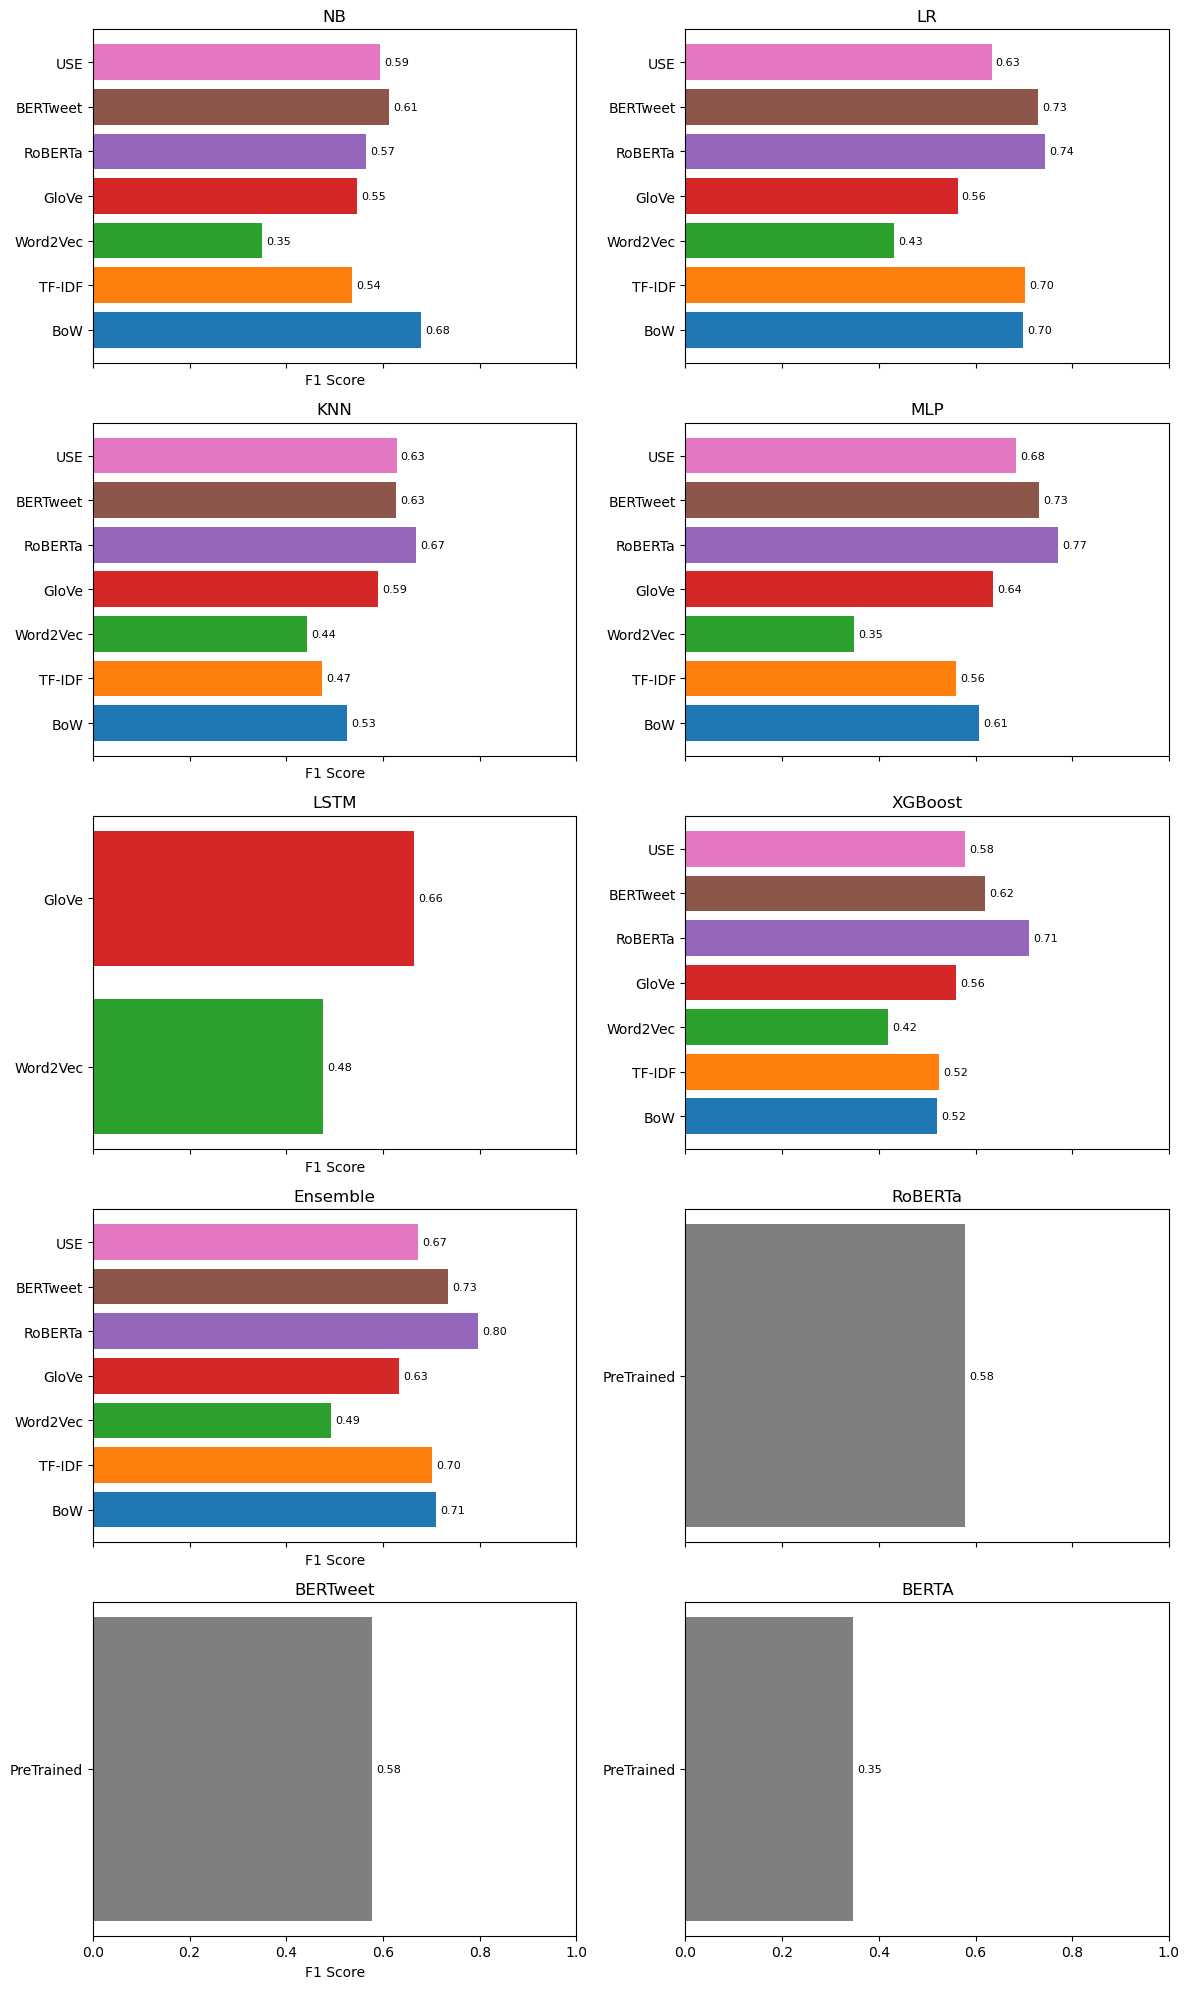

In [99]:
plot_f1_per_model(results_models)

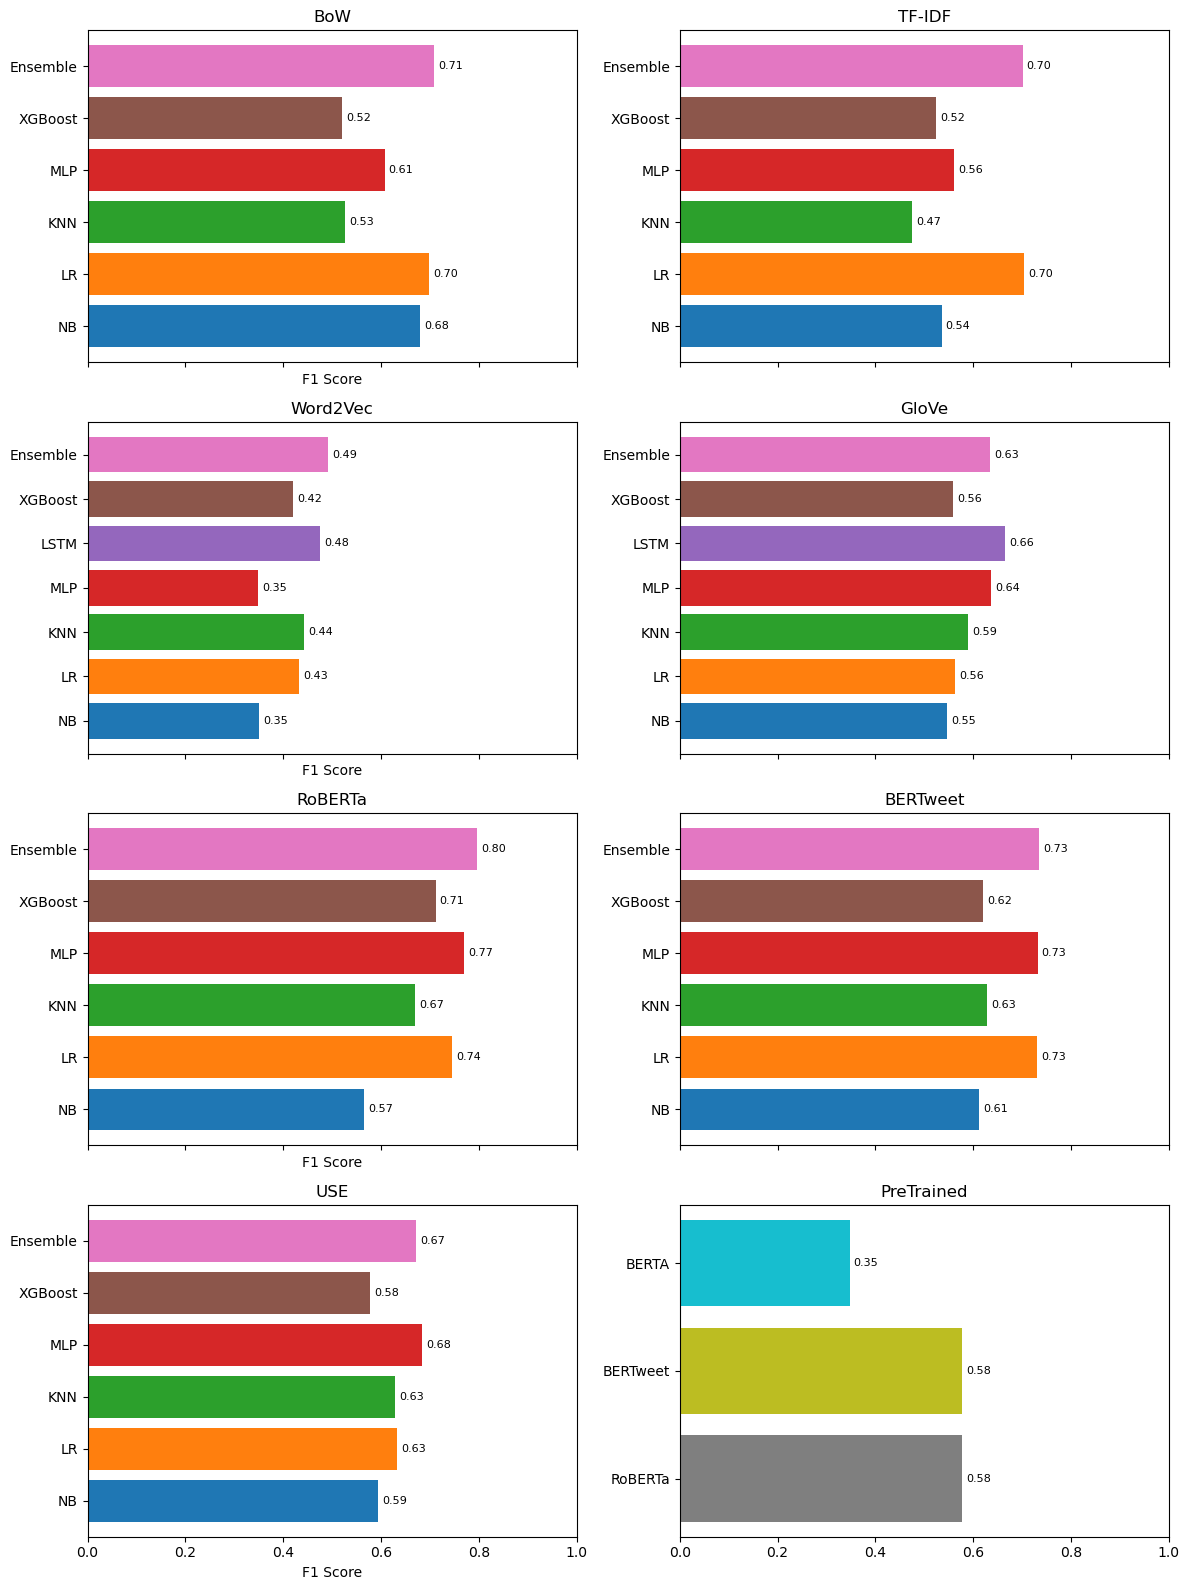

In [100]:
plot_f1_per_embedding(results_models)

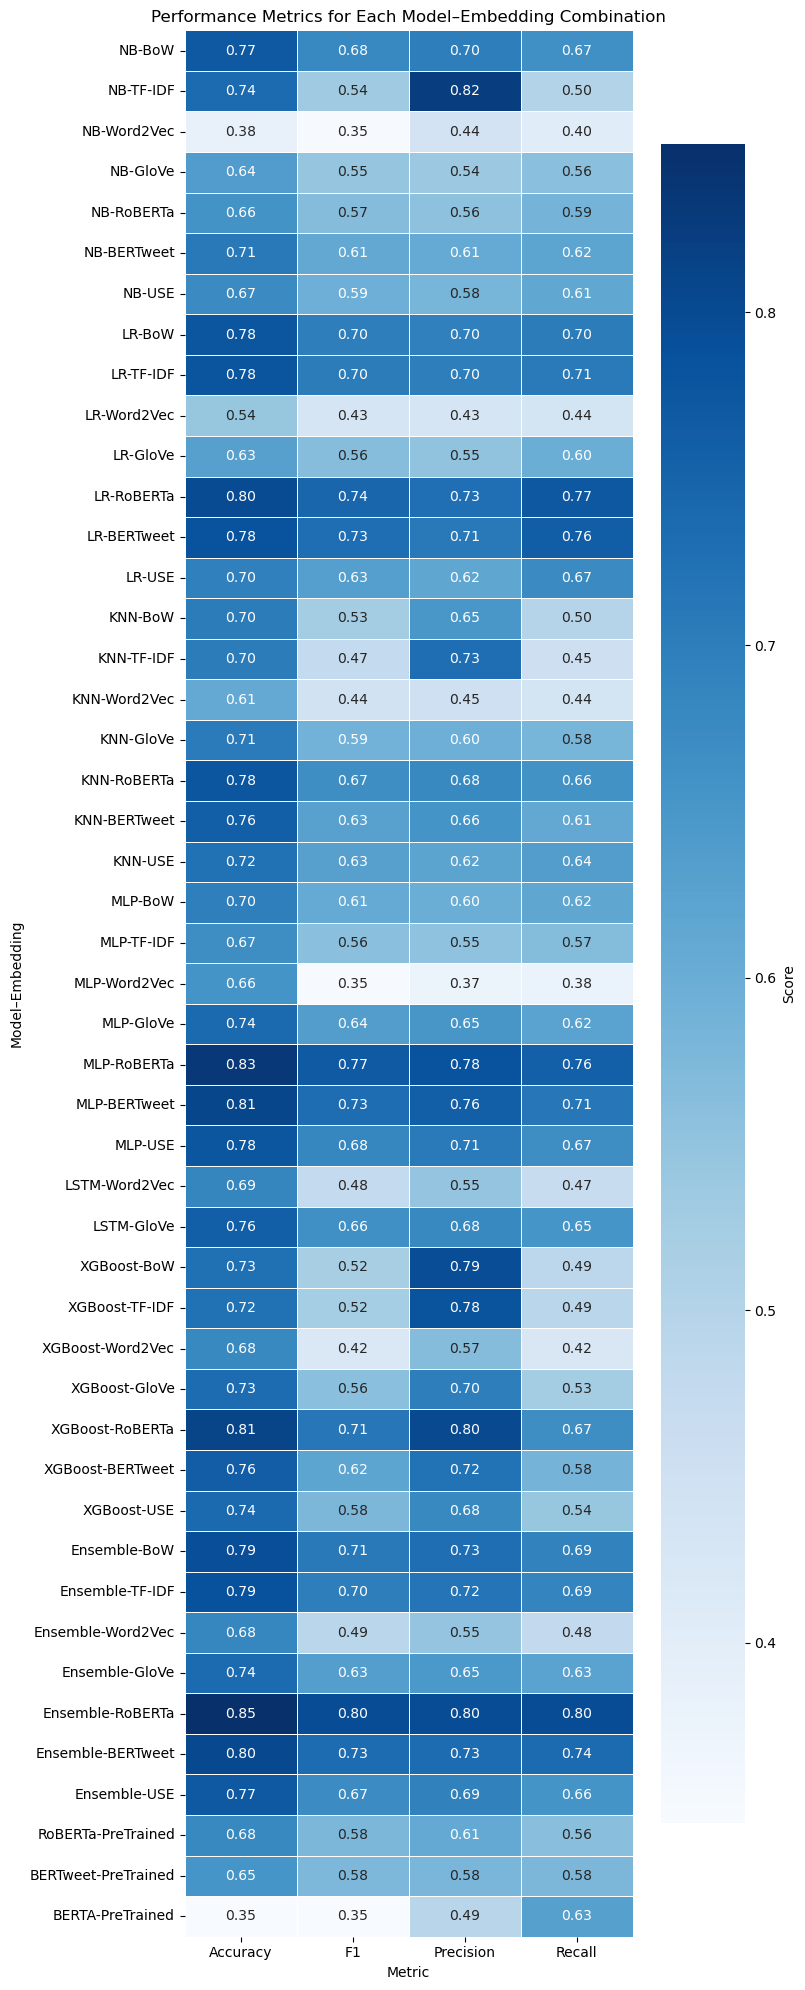

In [ ]:
# Prepare data for heatmap
df_f1 = results_models.replace("N/A", np.nan).astype(float)
df_acc  = pd.DataFrame(model_results_accuracy) .set_index('Models').replace("N/A", np.nan).astype(float)
df_prec = pd.DataFrame(model_results_precision).set_index('Models').replace("N/A", np.nan).astype(float)
df_rec  = pd.DataFrame(model_results_recall)   .set_index('Models').replace("N/A", np.nan).astype(float)

# Stack each into a Series
acc_series  = df_acc .stack().rename("Accuracy")
f1_series   = df_f1  .stack().rename("F1")
prec_series = df_prec.stack().rename("Precision")
rec_series  = df_rec .stack().rename("Recall")

# Concat into one long DataFrame
metrics = pd.concat([acc_series, f1_series, prec_series, rec_series], axis=1).reset_index()
metrics.columns = ["Model", "Embedding", "Accuracy", "F1", "Precision", "Recall"]

# Create a single index "Model-Embedding"
metrics["Combo"] = metrics["Model"] + "-" + metrics["Embedding"]
metrics_df = metrics.set_index("Combo")[["Accuracy", "F1", "Precision", "Recall"]]

# Plot the heatmap
plt.figure(figsize=(8, 20))
sns.heatmap(
    metrics_df,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    cbar_kws={'label': 'Score'},
    linewidths=0.5
)
plt.title("Performance Metrics for Each Model–Embedding Combination")
plt.xlabel("Metric")
plt.ylabel("Model–Embedding")
plt.tight_layout()
plt.show()

#### 2.5.3. Export Test Predictions

In [109]:
# predict on the test set using the best ensemble model
y_pred_test = ensemble.predict(df_test_roberta)
ids = df_test.index

final = pd.DataFrame({
    'id': ids,
    'label': y_pred_test
})

final.head(10)

,id,label
0,0,1
1,1,2
2,2,2
3,3,2
4,4,2
5,5,1
6,6,0
7,7,0
8,8,0
9,9,2


In [110]:
# Save the final predictions to a CSV file
final.to_csv('pred_07.csv', index=False, sep=';')